<a href="https://colab.research.google.com/github/TejasviBaddam/Automated-Detection-of-Diabetic-Retinopathy-Using-Convolutional-Neural-Networks-CNN-/blob/main/Data_V3_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install tqdm

In [1]:
!pip install opencv-python

In [2]:
!pip install tensorflow

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import shutil
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
from tqdm import tqdm
import cv2
from google.colab import files

In [5]:
dataset_path = "/content/drive/MyDrive/dataset/balanced_1500_dataset"

def load_images_from_folder(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = Image.open(img_path).resize((224, 224))
            img = np.array(img)
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images), np.array(labels)

healthy_folder = os.path.join(dataset_path, "healthy")
healthy_images, healthy_labels = load_images_from_folder(healthy_folder, label=0)

non_healthy_folder = os.path.join(dataset_path, "non_healthy")
non_healthy_images, non_healthy_labels = load_images_from_folder(non_healthy_folder, label=1)

X = np.concatenate((healthy_images, non_healthy_images), axis=0)
y = np.concatenate((healthy_labels, non_healthy_labels), axis=0)

print(f"Total images loaded: {X.shape[0]}")
print(f"Healthy images: {healthy_images.shape[0]}")
print(f"Non-healthy images: {non_healthy_images.shape[0]}")

Total images loaded: 3000
Healthy images: 1500
Non-healthy images: 1500


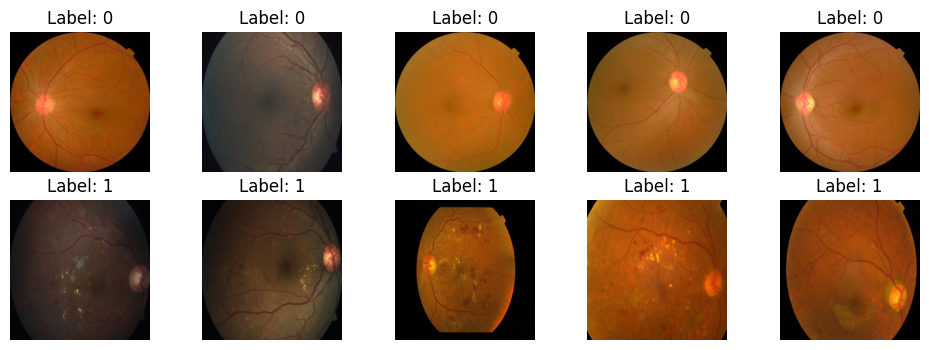

In [6]:
def show_sample_images(images, labels, num_images_per_label=5):
    unique_labels = np.unique(labels)

    plt.figure(figsize=(12, 2 * len(unique_labels)))

    for label_index, label in enumerate(unique_labels):
        label_indices = np.where(labels == label)[0]
        label_images = images[label_indices]
        label_labels = labels[label_indices]

        for i in range(num_images_per_label):
            plt.subplot(len(unique_labels), num_images_per_label, label_index * num_images_per_label + i + 1)
            plt.imshow(label_images[i])
            plt.title(f"Label: {label_labels[i]}")
            plt.axis('off')

    plt.show()

show_sample_images(X, y, num_images_per_label=5)

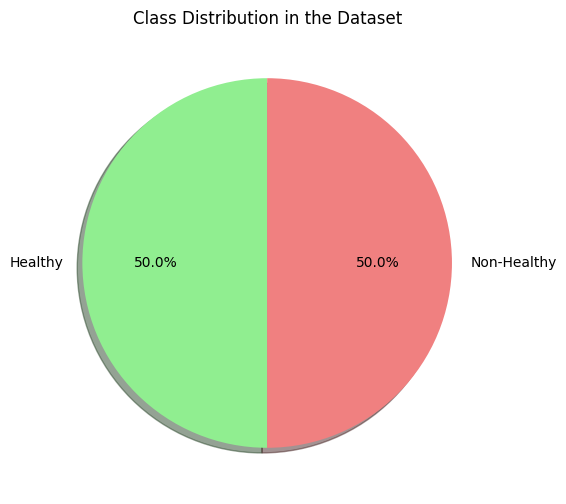

In [7]:
healthy_count = np.sum(y == 0)
non_healthy_count = np.sum(y == 1)

labels = ['Healthy', 'Non-Healthy']

sizes = [healthy_count, non_healthy_count]

colors = ['lightgreen', 'lightcoral']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, shadow=True)
plt.title('Class Distribution in the Dataset')
plt.show()

In [8]:
def apply_clahe(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    clahe_image = clahe.apply(gray_image)

    clahe_image = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2RGB)

    return clahe_image

X_clahe = np.array([apply_clahe(image) for image in X])

print(f"Shape of CLAHE-processed dataset: {X_clahe.shape}")

Shape of CLAHE-processed dataset: (3000, 224, 224, 3)


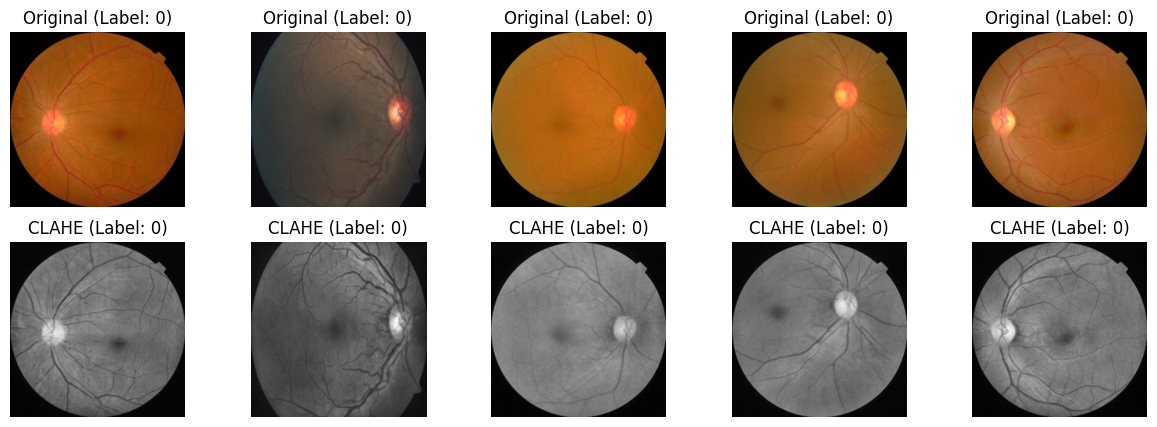

In [9]:
def show_original_vs_clahe(original_images, clahe_images, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images, i+1)
        plt.imshow(original_images[i])
        plt.title(f"Original (Label: {y[i]})")
        plt.axis('off')

        plt.subplot(2, num_images, i+num_images+1)
        plt.imshow(clahe_images[i])
        plt.title(f"CLAHE (Label: {y[i]})")
        plt.axis('off')
    plt.show()

show_original_vs_clahe(X, X_clahe, num_images=5)

In [10]:
np.save("/content/drive/MyDrive/dataset/X_clahe.npy", X_clahe)

In [11]:
X_clahe_normalized = X_clahe / 255.0


# Split the Dataset

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_clahe_normalized, y, test_size=0.1, random_state=42)

print(f"Training set: {X_train.shape[0]} images")
print(f"Testing set: {X_test.shape[0]} images")

Training set: 2700 images
Testing set: 300 images


#CNN Model

In [37]:
def build_cnn_model(input_shape=(224, 224, 3)):

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

model = build_cnn_model()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_97 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model


In [38]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - accuracy: 0.7707 - loss: 0.5452 - val_accuracy: 0.9067 - val_loss: 0.2021
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8999 - loss: 0.2543 - val_accuracy: 0.9267 - val_loss: 0.1974
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9227 - loss: 0.2366 - val_accuracy: 0.9233 - val_loss: 0.1748
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9187 - loss: 0.2342 - val_accuracy: 0.9167 - val_loss: 0.1810
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9207 - loss: 0.2295 - val_accuracy: 0.9433 - val_loss: 0.1721
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9435 - loss: 0.1900 - val_accuracy: 0.9200 - val_loss: 0.1759
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9257 - loss: 0.2244 - val_accuracy: 0.9300 - val_loss: 0.1736
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9413 - loss: 0.1741 - val_accuracy: 0.9400 - v

# Evaluate the model on the test set


In [39]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.2570
Test Accuracy: 0.9267


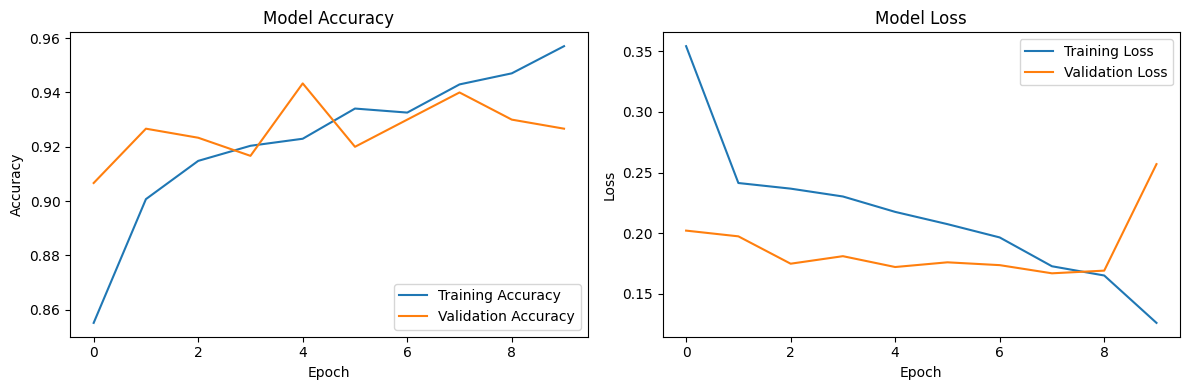

In [40]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       155
           1       0.90      0.96      0.93       145

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



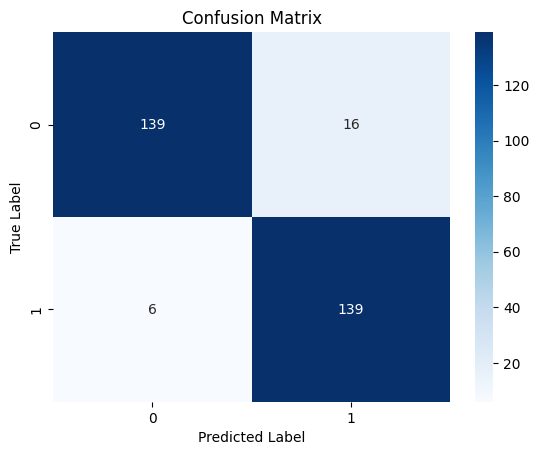

In [41]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [42]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

train_generator = datagen.flow(X_train, y_train, batch_size=32)

history = model.fit(train_generator,
                    epochs=30,
                    validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 297ms/step - accuracy: 0.6275 - loss: 0.8300 - val_accuracy: 0.9000 - val_loss: 0.2425
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step - accuracy: 0.8365 - loss: 0.3776 - val_accuracy: 0.9067 - val_loss: 0.2126
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step - accuracy: 0.8598 - loss: 0.3404 - val_accuracy: 0.9067 - val_loss: 0.2161
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 296ms/step - accuracy: 0.8605 - loss: 0.3211 - val_accuracy: 0.9000 - val_loss: 0.2034
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 292ms/step - accuracy: 0.8638 - loss: 0.3271 - val_accuracy: 0.9033 - val_loss: 0.2057
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 289ms/step - accuracy: 0.8670 - loss: 0.3259 - val_accuracy: 0.9000 - val_loss: 0.2172
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 294ms/step - accuracy: 0.8869 - loss: 0.2796 - val_accuracy: 0.9033 - val_loss: 0.2085
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 292ms/step - accuracy: 0.8855 - loss: 0.2860 - val_accu

In [43]:
model.save('/content/drive/MyDrive/dataset/balanced_1500_dataset/my_cnn_model.keras')
print("Model saved successfully!")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Model saved successfully!
Test Loss: 0.1734
Test Accuracy: 0.9367


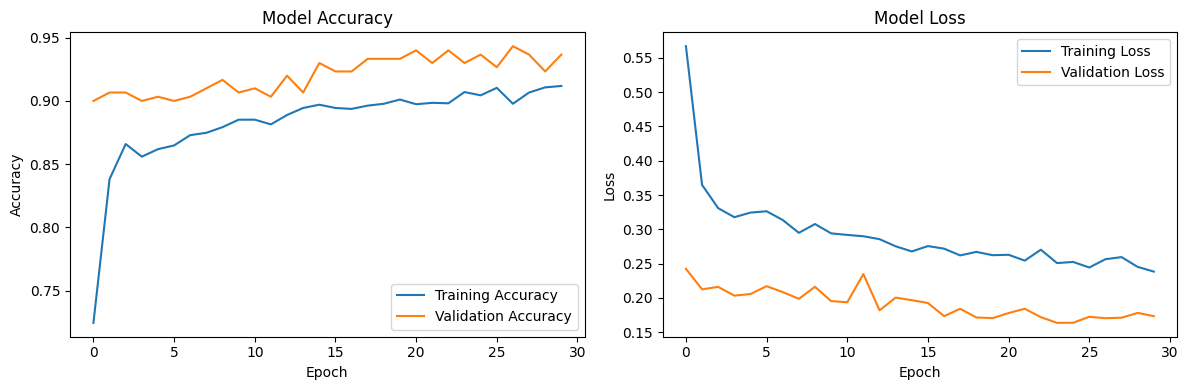

In [44]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       155
           1       0.96      0.90      0.93       145

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



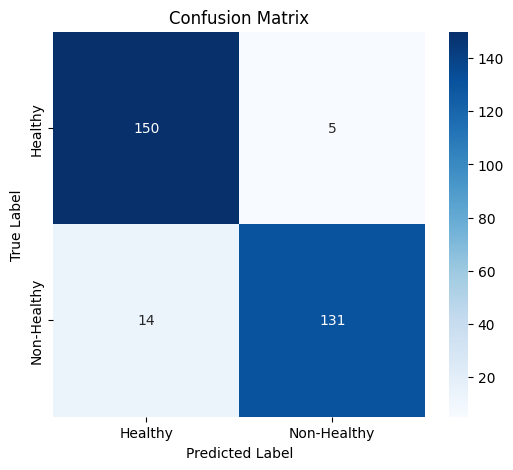

In [45]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Non-Healthy'], yticklabels=['Healthy', 'Non-Healthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Load pre-trained ResNet50 model

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 44s 397ms/step - accuracy: 0.5062 - loss: 0.8026 - val_accuracy: 0.7233 - val_loss: 0.6695 - learning_rate: 1.0000e-04
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 301ms/step - accuracy: 0.5261 - loss: 0.7269 - val_accuracy: 0.5700 - val_loss: 0.6629 - learning_rate: 1.0000e-04
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 306ms/step - accuracy: 0.5406 - loss: 0.6968 - val_accuracy: 0.6600 - val_loss: 0.6515 - learning_rate: 1.0000e-04
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 304ms/step - accuracy: 0.5731 - loss: 0.6765 - val_accuracy: 0.8667 - val_loss: 0.6362 - learning_rate: 1.0000e-04
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 298ms/step - accuracy: 0.6211 - loss: 0.6596 - val_accuracy: 0.8833 - val_loss: 0.6273 - learning_rate: 1.0000e-04
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 302ms/step - accuracy: 0.6228 - loss: 0.6593 - val_accuracy: 0.7567 - val_loss: 0.6164 - learning_rate: 1.0000e-04
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 304ms/step - acc

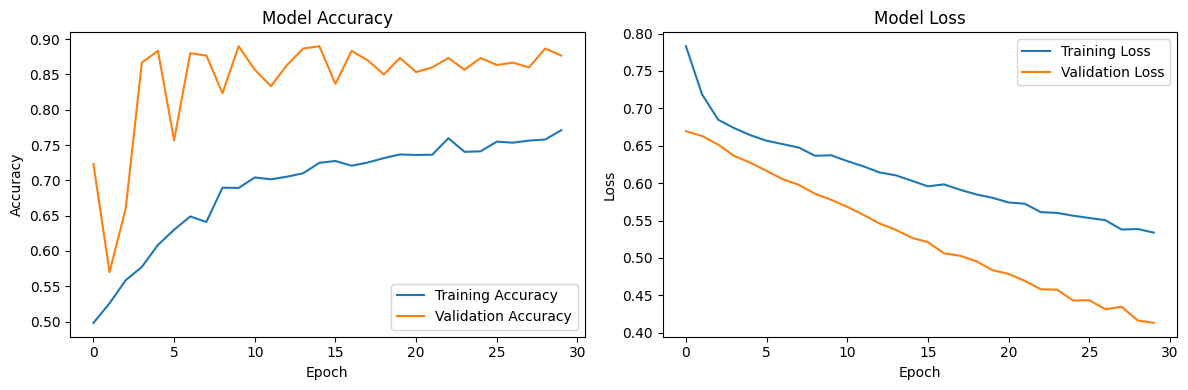

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 430ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       155
           1       0.90      0.84      0.87       145

    accuracy                           0.88       300
   macro avg       0.88      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300



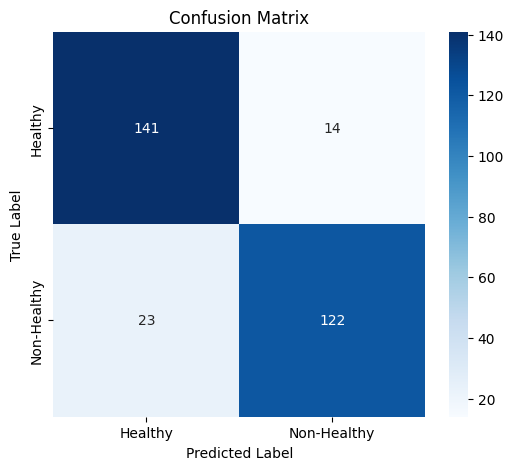

In [46]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2)
    ]
)


# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Classification Report and Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Non-Healthy'], yticklabels=['Healthy', 'Non-Healthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [47]:
model.save('/content/drive/MyDrive/dataset/balanced_1500_dataset/my_resnet50model.keras')
print("Model saved successfully!")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Model saved successfully!
Test Loss: 0.4131
Test Accuracy: 0.8767


# Pre-Trained InceptionV3 Model

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_194 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_188   │ (None, 111, 111, 32)   │             96 │ conv2d_194[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 111, 111, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_195 (Conv2D)       │ (None, 109, 109, 32)   │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 109, 109, 32)   │             96 │ conv2d_195[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_196 (Conv2D)       │ (None, 109, 109, 64)   │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 109, 109, 64)   │            192 │ conv2d_196[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 109, 109, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 54, 54, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_197 (Conv2D)       │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 54, 54, 80)     │            240 │ conv2d_197[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 54, 54, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_198 (Conv2D)  

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 48s 437ms/step - accuracy: 0.6994 - loss: 0.5566 - val_accuracy: 0.8267 - val_loss: 0.3845 - learning_rate: 1.0000e-04
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 304ms/step - accuracy: 0.8598 - loss: 0.3357 - val_accuracy: 0.8733 - val_loss: 0.2844 - learning_rate: 1.0000e-04
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 302ms/step - accuracy: 0.8824 - loss: 0.2824 - val_accuracy: 0.8767 - val_loss: 0.2787 - learning_rate: 1.0000e-04
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 303ms/step - accuracy: 0.8959 - loss: 0.2584 - val_accuracy: 0.8833 - val_loss: 0.2572 - learning_rate: 1.0000e-04
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 301ms/step - accuracy: 0.8918 - loss: 0.2738 - val_accuracy: 0.8967 - val_loss: 0.2382 - learning_rate: 1.0000e-04
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 25s 299ms/step - accuracy: 0.8988 - loss: 0.2538 - val_accuracy: 0.8900 - val_loss: 0.2223 - learning_rate: 1.0000e-04
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 303ms/step - acc

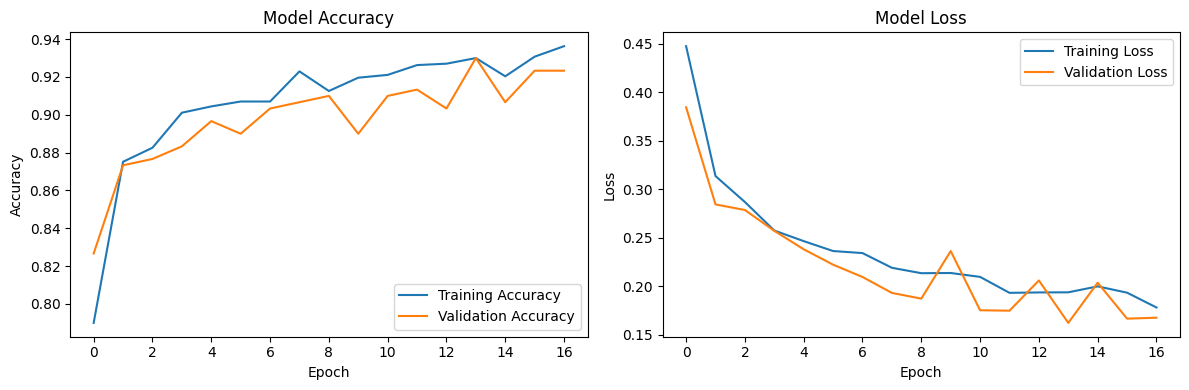

10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 605ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       155
           1       0.96      0.90      0.93       145

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



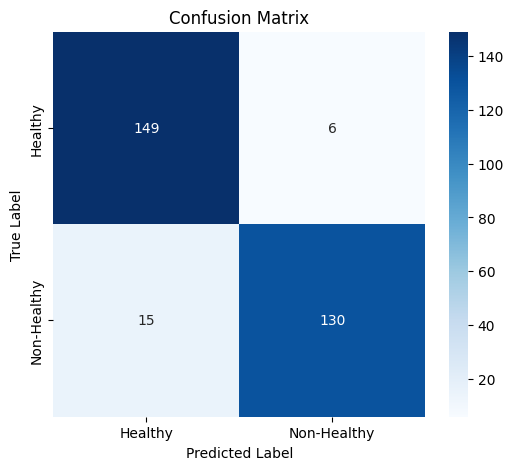

In [50]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,  # Use the augmented data generator
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2)
    ]
)


# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Classification Report and Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Non-Healthy'], yticklabels=['Healthy', 'Non-Healthy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [51]:
# Save the InceptionV3 model
model.save('/content/drive/MyDrive/dataset/balanced_1500_dataset/my_inceptionv3_model.keras')
print("Model saved successfully!")

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Model saved successfully!
Test Loss: 0.1623
Test Accuracy: 0.9300


In [52]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/dataset/balanced_1500_dataset/my_inceptionv3_model.keras')
print("Model loaded successfully!")

# Evaluate the loaded model (optional)
loss, accuracy = loaded_model.evaluate(X_test, y_test, verbose=0)
print(f"Loaded Model Test Loss: {loss:.4f}")
print(f"Loaded Model Test Accuracy: {accuracy:.4f}")

Model loaded successfully!
Loaded Model Test Loss: 0.1623
Loaded Model Test Accuracy: 0.9300


In [32]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tqdm import tqdm  # Import tqdm for the progress bar

# Load the saved model
model = load_model('/content/drive/MyDrive/dataset/balanced_1500_dataset/my_inceptionv3_model.keras')

# Paths
test_folder = "/content/drive/MyDrive/dataset/test_images"
test_csv = "/content/drive/MyDrive/dataset/test.csv"

# Load the test CSV file
test_df = pd.read_csv(test_csv)

# Function to preprocess a single image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to make predictions
def predict_image(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        return "Non-Healthy (DR Detected)"
    else:
        return "Healthy (No DR)"

# Predict on all test images and save results
results = []
for idx, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Processing"):  # Single progress bar
    img_name = row["id_code"] + ".png"  # Assuming images are in PNG format
    img_path = os.path.join(test_folder, img_name)
    if os.path.exists(img_path):
        result = predict_image(img_path)
        results.append((img_name, result))
    else:
        results.append((img_name, "Image Not Found"))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=["id_code", "prediction"])

# Save results to a CSV file
results_df.to_csv("/content/drive/MyDrive/dataset/balanced_1500_dataset/test_predictions.csv", index=False)
print("Predictions saved successfully!")

Processing:   0%|          | 0/1928 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Processing:   0%|          | 1/1928 [00:04<2:32:33,  4.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:   0%|          | 3/1928 [00:04<41:40,  1.30s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   0%|          | 5/1928 [00:05<21:37,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   0%|          | 7/1928 [00:05<14:20,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   0%|          | 8/1928 [00:05<11:50,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   1%|          | 10/1928 [00:05<08:12,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   1%|          | 11/1928 [00:05<07:42,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing:   1%|          | 13/1928 [00:06<05:45,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   1%|          | 15/1928 [00:06<05:13,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:   1%|          | 16/1928 [00:06<05:33,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   1%|          | 18/1928 [00:06<04:31,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   1%|          | 20/1928 [00:06<04:03,  7.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:   1%|          | 22/1928 [00:07<03:35,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:   1%|          | 24/1928 [00:07<03:18,  9.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:   1%|▏         | 26/1928 [00:07<03:06, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:   1%|▏         | 28/1928 [00:07<03:29,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   2%|▏         | 30/1928 [00:07<03:18,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   2%|▏         | 32/1928 [00:08<03:08, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   2%|▏         | 34/1928 [00:08<03:04, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:   2%|▏         | 36/1928 [00:08<02:58, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   2%|▏         | 38/1928 [00:08<02:55, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:   2%|▏         | 40/1928 [00:08<02:56, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   2%|▏         | 42/1928 [00:09<03:32,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:   2%|▏         | 43/1928 [00:09<04:16,  7.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   2%|▏         | 45/1928 [00:09<04:16,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   2%|▏         | 47/1928 [00:09<04:17,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:   3%|▎         | 49/1928 [00:10<03:46,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   3%|▎         | 50/1928 [00:10<04:10,  7.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   3%|▎         | 52/1928 [00:10<03:39,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   3%|▎         | 54/1928 [00:10<03:20,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:   3%|▎         | 56/1928 [00:10<03:07,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   3%|▎         | 58/1928 [00:10<03:08,  9.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   3%|▎         | 60/1928 [00:11<03:09,  9.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:   3%|▎         | 61/1928 [00:11<03:09,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   3%|▎         | 63/1928 [00:11<03:33,  8.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:   3%|▎         | 65/1928 [00:11<03:20,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   3%|▎         | 67/1928 [00:11<03:11,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   4%|▎         | 69/1928 [00:12<03:01, 10.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   4%|▎         | 71/1928 [00:12<03:25,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   4%|▍         | 73/1928 [00:12<03:09,  9.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   4%|▍         | 75/1928 [00:12<03:36,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   4%|▍         | 77/1928 [00:12<03:20,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   4%|▍         | 79/1928 [00:13<03:09,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   4%|▍         | 81/1928 [00:13<03:02, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:   4%|▍         | 83/1928 [00:13<02:58, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   4%|▍         | 85/1928 [00:13<03:20,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:   5%|▍         | 87/1928 [00:13<03:08,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:   5%|▍         | 89/1928 [00:14<03:29,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:   5%|▍         | 90/1928 [00:14<03:54,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:   5%|▍         | 92/1928 [00:14<04:01,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:   5%|▍         | 93/1928 [00:14<04:27,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   5%|▍         | 94/1928 [00:15<04:16,  7.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:   5%|▍         | 96/1928 [00:15<03:37,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   5%|▌         | 98/1928 [00:15<03:47,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   5%|▌         | 100/1928 [00:15<03:24,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   5%|▌         | 102/1928 [00:15<03:10,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   5%|▌         | 104/1928 [00:16<03:02,  9.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:   5%|▌         | 106/1928 [00:16<02:53, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:   6%|▌         | 108/1928 [00:16<03:19,  9.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:   6%|▌         | 110/1928 [00:16<03:06,  9.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   6%|▌         | 112/1928 [00:16<02:57, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   6%|▌         | 114/1928 [00:17<03:25,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   6%|▌         | 115/1928 [00:17<03:50,  7.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:   6%|▌         | 117/1928 [00:17<03:25,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   6%|▌         | 119/1928 [00:17<03:09,  9.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   6%|▋         | 121/1928 [00:17<03:20,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   6%|▋         | 122/1928 [00:18<03:35,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:   6%|▋         | 124/1928 [00:18<03:45,  7.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:   6%|▋         | 125/1928 [00:18<04:16,  7.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:   7%|▋         | 127/1928 [00:18<04:17,  6.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   7%|▋         | 128/1928 [00:19<04:32,  6.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:   7%|▋         | 130/1928 [00:19<04:23,  6.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:   7%|▋         | 131/1928 [00:19<04:12,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   7%|▋         | 133/1928 [00:19<03:42,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   7%|▋         | 134/1928 [00:19<03:42,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:   7%|▋         | 136/1928 [00:19<03:22,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing:   7%|▋         | 137/1928 [00:20<03:20,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   7%|▋         | 139/1928 [00:20<03:11,  9.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:   7%|▋         | 141/1928 [00:20<03:31,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:   7%|▋         | 143/1928 [00:20<03:12,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:   8%|▊         | 145/1928 [00:20<03:00,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:   8%|▊         | 147/1928 [00:21<03:14,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   8%|▊         | 148/1928 [00:21<03:39,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:   8%|▊         | 149/1928 [00:21<03:55,  7.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:   8%|▊         | 151/1928 [00:21<04:09,  7.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   8%|▊         | 153/1928 [00:21<03:35,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   8%|▊         | 155/1928 [00:22<03:18,  8.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   8%|▊         | 156/1928 [00:22<03:43,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:   8%|▊         | 158/1928 [00:22<03:18,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:   8%|▊         | 160/1928 [00:22<03:04,  9.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   8%|▊         | 162/1928 [00:22<02:54, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   9%|▊         | 164/1928 [00:23<02:48, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:   9%|▊         | 166/1928 [00:23<02:46, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   9%|▊         | 168/1928 [00:23<03:06,  9.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   9%|▉         | 170/1928 [00:23<02:58,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:   9%|▉         | 172/1928 [00:23<02:51, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   9%|▉         | 174/1928 [00:24<02:55, 10.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   9%|▉         | 176/1928 [00:24<02:49, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:   9%|▉         | 178/1928 [00:24<03:13,  9.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:   9%|▉         | 180/1928 [00:24<03:01,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:   9%|▉         | 182/1928 [00:24<02:51, 10.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  10%|▉         | 184/1928 [00:25<02:48, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  10%|▉         | 186/1928 [00:25<03:11,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  10%|▉         | 188/1928 [00:25<03:02,  9.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  10%|▉         | 190/1928 [00:25<03:42,  7.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  10%|▉         | 192/1928 [00:26<03:47,  7.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  10%|█         | 194/1928 [00:26<03:57,  7.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  10%|█         | 196/1928 [00:26<03:35,  8.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  10%|█         | 198/1928 [00:26<03:29,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  10%|█         | 200/1928 [00:27<03:13,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  10%|█         | 202/1928 [00:27<03:01,  9.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  11%|█         | 203/1928 [00:27<03:46,  7.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  11%|█         | 204/1928 [00:27<03:37,  7.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:  11%|█         | 206/1928 [00:27<03:17,  8.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  11%|█         | 207/1928 [00:27<03:48,  7.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  11%|█         | 209/1928 [00:28<03:21,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  11%|█         | 211/1928 [00:28<03:03,  9.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  11%|█         | 212/1928 [00:28<03:29,  8.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  11%|█         | 214/1928 [00:28<03:08,  9.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:  11%|█         | 216/1928 [00:28<02:55,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  11%|█▏        | 217/1928 [00:29<03:34,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:  11%|█▏        | 219/1928 [00:29<03:09,  9.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  11%|█▏        | 221/1928 [00:30<07:15,  3.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  12%|█▏        | 222/1928 [00:31<11:01,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  12%|█▏        | 223/1928 [00:32<14:58,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  12%|█▏        | 224/1928 [00:33<18:00,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  12%|█▏        | 225/1928 [00:33<18:26,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  12%|█▏        | 226/1928 [00:34<19:15,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  12%|█▏        | 227/1928 [00:35<22:23,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  12%|█▏        | 228/1928 [00:36<21:53,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  12%|█▏        | 229/1928 [00:37<21:53,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  12%|█▏        | 230/1928 [00:38<25:15,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  12%|█▏        | 231/1928 [00:39<23:55,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  12%|█▏        | 232/1928 [00:40<25:40,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  12%|█▏        | 233/1928 [00:41<28:23,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  12%|█▏        | 234/1928 [00:42<31:12,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  12%|█▏        | 235/1928 [00:44<31:43,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  12%|█▏        | 236/1928 [00:44<30:07,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  12%|█▏        | 237/1928 [00:45<28:49,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  12%|█▏        | 238/1928 [00:46<26:05,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  12%|█▏        | 239/1928 [00:47<28:25,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  12%|█▏        | 240/1928 [00:48<25:48,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  12%|█▎        | 241/1928 [00:49<24:32,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  13%|█▎        | 242/1928 [00:49<22:59,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  13%|█▎        | 243/1928 [00:50<24:37,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  13%|█▎        | 244/1928 [00:51<25:21,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  13%|█▎        | 245/1928 [00:52<25:52,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  13%|█▎        | 246/1928 [00:53<24:42,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  13%|█▎        | 247/1928 [00:54<23:55,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  13%|█▎        | 248/1928 [00:55<22:34,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  13%|█▎        | 249/1928 [00:56<22:49,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  13%|█▎        | 250/1928 [00:56<23:36,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  13%|█▎        | 251/1928 [00:57<24:18,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  13%|█▎        | 252/1928 [00:58<24:38,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  13%|█▎        | 253/1928 [00:59<26:07,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  13%|█▎        | 254/1928 [01:00<27:05,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  13%|█▎        | 255/1928 [01:01<25:10,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  13%|█▎        | 256/1928 [01:02<25:22,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  13%|█▎        | 257/1928 [01:03<26:09,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  13%|█▎        | 258/1928 [01:04<25:29,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  13%|█▎        | 259/1928 [01:05<26:46,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  13%|█▎        | 260/1928 [01:06<29:47,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  14%|█▎        | 261/1928 [01:07<28:23,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  14%|█▎        | 262/1928 [01:08<26:24,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  14%|█▎        | 263/1928 [01:09<25:55,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  14%|█▎        | 264/1928 [01:10<27:13,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  14%|█▎        | 265/1928 [01:11<25:11,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  14%|█▍        | 266/1928 [01:11<23:47,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  14%|█▍        | 267/1928 [01:13<26:16,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  14%|█▍        | 268/1928 [01:13<24:25,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  14%|█▍        | 269/1928 [01:15<28:06,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  14%|█▍        | 270/1928 [01:15<25:49,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  14%|█▍        | 271/1928 [01:17<29:45,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  14%|█▍        | 272/1928 [01:18<29:45,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  14%|█▍        | 273/1928 [01:19<30:15,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  14%|█▍        | 274/1928 [01:20<28:00,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  14%|█▍        | 275/1928 [01:21<26:18,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  14%|█▍        | 276/1928 [01:22<27:31,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  14%|█▍        | 277/1928 [01:23<28:41,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  14%|█▍        | 278/1928 [01:24<31:25,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  14%|█▍        | 279/1928 [01:26<32:16,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  15%|█▍        | 280/1928 [01:27<30:20,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  15%|█▍        | 281/1928 [01:27<28:20,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  15%|█▍        | 282/1928 [01:28<27:21,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  15%|█▍        | 283/1928 [01:29<27:01,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  15%|█▍        | 284/1928 [01:30<26:19,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  15%|█▍        | 285/1928 [01:31<26:12,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  15%|█▍        | 286/1928 [01:32<25:44,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  15%|█▍        | 287/1928 [01:33<26:01,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  15%|█▍        | 288/1928 [01:34<23:43,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  15%|█▍        | 289/1928 [01:35<25:27,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  15%|█▌        | 290/1928 [01:36<25:28,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  15%|█▌        | 291/1928 [01:37<25:29,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  15%|█▌        | 292/1928 [01:38<27:21,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  15%|█▌        | 293/1928 [01:39<27:32,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  15%|█▌        | 294/1928 [01:40<29:19,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  15%|█▌        | 295/1928 [01:41<27:51,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  15%|█▌        | 296/1928 [01:42<27:40,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  15%|█▌        | 297/1928 [01:43<27:28,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  15%|█▌        | 298/1928 [01:44<24:53,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  16%|█▌        | 299/1928 [01:45<30:11,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  16%|█▌        | 300/1928 [01:46<30:52,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  16%|█▌        | 301/1928 [01:47<29:14,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  16%|█▌        | 302/1928 [01:48<27:36,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  16%|█▌        | 303/1928 [01:49<25:11,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  16%|█▌        | 304/1928 [01:50<23:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  16%|█▌        | 305/1928 [01:51<25:26,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  16%|█▌        | 306/1928 [01:51<23:50,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  16%|█▌        | 307/1928 [01:52<24:15,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  16%|█▌        | 308/1928 [01:53<24:33,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  16%|█▌        | 309/1928 [01:55<30:56,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  16%|█▌        | 310/1928 [01:56<28:52,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  16%|█▌        | 311/1928 [01:57<28:29,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  16%|█▌        | 312/1928 [01:58<26:04,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  16%|█▌        | 313/1928 [01:59<26:16,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  16%|█▋        | 314/1928 [02:00<26:20,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  16%|█▋        | 315/1928 [02:01<31:31,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  16%|█▋        | 316/1928 [02:02<27:55,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  16%|█▋        | 317/1928 [02:03<28:59,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  16%|█▋        | 318/1928 [02:04<28:54,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  17%|█▋        | 319/1928 [02:05<26:03,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  17%|█▋        | 320/1928 [02:06<24:31,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  17%|█▋        | 321/1928 [02:07<24:38,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  17%|█▋        | 322/1928 [02:08<23:31,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  17%|█▋        | 323/1928 [02:08<23:32,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  17%|█▋        | 324/1928 [02:09<23:36,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  17%|█▋        | 325/1928 [02:10<23:55,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  17%|█▋        | 326/1928 [02:11<22:28,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  17%|█▋        | 327/1928 [02:12<23:38,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  17%|█▋        | 328/1928 [02:13<24:15,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  17%|█▋        | 329/1928 [02:14<23:40,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  17%|█▋        | 330/1928 [02:15<24:38,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  17%|█▋        | 331/1928 [02:16<26:16,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  17%|█▋        | 332/1928 [02:17<26:04,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  17%|█▋        | 333/1928 [02:18<26:18,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  17%|█▋        | 334/1928 [02:19<24:17,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  17%|█▋        | 335/1928 [02:19<23:57,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  17%|█▋        | 336/1928 [02:21<24:49,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  17%|█▋        | 337/1928 [02:21<23:09,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  18%|█▊        | 338/1928 [02:22<22:02,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  18%|█▊        | 339/1928 [02:23<22:44,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  18%|█▊        | 340/1928 [02:24<24:10,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  18%|█▊        | 341/1928 [02:25<26:10,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  18%|█▊        | 342/1928 [02:26<25:07,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  18%|█▊        | 343/1928 [02:27<26:10,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  18%|█▊        | 344/1928 [02:28<24:52,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  18%|█▊        | 345/1928 [02:29<22:40,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  18%|█▊        | 346/1928 [02:30<24:26,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  18%|█▊        | 347/1928 [02:31<24:47,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  18%|█▊        | 348/1928 [02:31<23:31,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing:  18%|█▊        | 349/1928 [02:32<24:28,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:  18%|█▊        | 350/1928 [02:34<26:08,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  18%|█▊        | 351/1928 [02:34<24:35,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing:  18%|█▊        | 352/1928 [02:35<23:15,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  18%|█▊        | 353/1928 [02:36<21:58,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  18%|█▊        | 354/1928 [02:37<23:14,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  18%|█▊        | 355/1928 [02:38<23:57,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  18%|█▊        | 356/1928 [02:39<22:32,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  19%|█▊        | 357/1928 [02:39<22:56,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  19%|█▊        | 358/1928 [02:40<24:11,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  19%|█▊        | 359/1928 [02:41<24:17,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  19%|█▊        | 360/1928 [02:42<24:02,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  19%|█▊        | 361/1928 [02:43<22:40,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  19%|█▉        | 362/1928 [02:44<25:06,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  19%|█▉        | 363/1928 [02:45<23:37,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  19%|█▉        | 364/1928 [02:46<24:15,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  19%|█▉        | 365/1928 [02:47<22:50,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  19%|█▉        | 366/1928 [02:48<23:10,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  19%|█▉        | 367/1928 [02:49<24:22,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  19%|█▉        | 368/1928 [02:49<22:47,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  19%|█▉        | 369/1928 [02:50<23:05,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  19%|█▉        | 370/1928 [02:51<21:56,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  19%|█▉        | 371/1928 [02:52<22:33,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  19%|█▉        | 372/1928 [02:53<24:28,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  19%|█▉        | 373/1928 [02:54<23:52,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  19%|█▉        | 374/1928 [02:55<26:07,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  19%|█▉        | 375/1928 [02:57<29:37,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  20%|█▉        | 376/1928 [02:58<29:24,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  20%|█▉        | 377/1928 [02:59<29:39,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  20%|█▉        | 378/1928 [03:00<28:09,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  20%|█▉        | 379/1928 [03:01<27:21,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  20%|█▉        | 380/1928 [03:02<26:41,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  20%|█▉        | 381/1928 [03:03<24:36,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  20%|█▉        | 382/1928 [03:03<22:59,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  20%|█▉        | 383/1928 [03:05<24:41,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  20%|█▉        | 384/1928 [03:05<23:59,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  20%|█▉        | 385/1928 [03:06<24:24,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  20%|██        | 386/1928 [03:07<24:21,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  20%|██        | 387/1928 [03:08<23:49,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  20%|██        | 388/1928 [03:09<22:33,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  20%|██        | 389/1928 [03:10<22:19,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  20%|██        | 390/1928 [03:11<22:34,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  20%|██        | 391/1928 [03:12<22:32,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  20%|██        | 392/1928 [03:13<23:35,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  20%|██        | 393/1928 [03:14<23:27,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  20%|██        | 394/1928 [03:15<24:10,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  20%|██        | 395/1928 [03:16<24:03,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  21%|██        | 396/1928 [03:16<24:13,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  21%|██        | 397/1928 [03:17<23:37,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  21%|██        | 398/1928 [03:18<24:08,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  21%|██        | 399/1928 [03:19<25:20,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  21%|██        | 400/1928 [03:20<24:52,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  21%|██        | 401/1928 [03:21<24:51,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  21%|██        | 402/1928 [03:22<25:32,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  21%|██        | 403/1928 [03:23<24:43,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  21%|██        | 404/1928 [03:24<23:05,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  21%|██        | 405/1928 [03:25<23:43,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  21%|██        | 406/1928 [03:26<23:18,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  21%|██        | 407/1928 [03:27<24:55,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  21%|██        | 408/1928 [03:28<25:36,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  21%|██        | 409/1928 [03:29<26:29,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  21%|██▏       | 410/1928 [03:30<26:39,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  21%|██▏       | 411/1928 [03:31<26:03,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  21%|██▏       | 412/1928 [03:32<26:41,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  21%|██▏       | 413/1928 [03:33<26:13,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  21%|██▏       | 414/1928 [03:34<24:43,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  22%|██▏       | 415/1928 [03:35<23:32,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  22%|██▏       | 416/1928 [03:37<26:50,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  22%|██▏       | 417/1928 [03:37<24:37,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  22%|██▏       | 418/1928 [03:38<23:03,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  22%|██▏       | 419/1928 [03:39<21:21,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  22%|██▏       | 420/1928 [03:40<22:15,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  22%|██▏       | 421/1928 [03:41<22:27,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  22%|██▏       | 422/1928 [03:42<28:12,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  22%|██▏       | 423/1928 [03:44<30:07,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  22%|██▏       | 424/1928 [03:44<26:28,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  22%|██▏       | 425/1928 [03:46<27:13,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  22%|██▏       | 426/1928 [03:47<26:10,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  22%|██▏       | 427/1928 [03:47<24:53,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  22%|██▏       | 428/1928 [03:48<23:06,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  22%|██▏       | 429/1928 [03:49<21:13,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  22%|██▏       | 430/1928 [03:50<21:06,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  22%|██▏       | 431/1928 [03:50<20:10,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  22%|██▏       | 432/1928 [03:51<20:47,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  22%|██▏       | 433/1928 [03:52<19:57,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  23%|██▎       | 434/1928 [03:53<21:46,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  23%|██▎       | 435/1928 [03:54<23:21,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  23%|██▎       | 436/1928 [03:55<21:39,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  23%|██▎       | 437/1928 [03:56<21:30,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  23%|██▎       | 438/1928 [03:57<22:17,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  23%|██▎       | 439/1928 [03:58<22:16,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  23%|██▎       | 440/1928 [03:58<21:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  23%|██▎       | 441/1928 [03:59<19:51,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  23%|██▎       | 442/1928 [04:00<21:45,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  23%|██▎       | 443/1928 [04:01<22:04,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  23%|██▎       | 444/1928 [04:02<20:52,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  23%|██▎       | 445/1928 [04:03<23:27,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  23%|██▎       | 446/1928 [04:04<22:07,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  23%|██▎       | 447/1928 [04:05<25:37,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  23%|██▎       | 448/1928 [04:06<26:22,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  23%|██▎       | 449/1928 [04:07<24:25,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  23%|██▎       | 450/1928 [04:08<24:19,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  23%|██▎       | 451/1928 [04:09<24:21,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  23%|██▎       | 452/1928 [04:10<24:25,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  23%|██▎       | 453/1928 [04:11<24:24,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  24%|██▎       | 454/1928 [04:12<23:51,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  24%|██▎       | 455/1928 [04:13<22:45,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  24%|██▎       | 456/1928 [04:13<21:33,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  24%|██▎       | 457/1928 [04:14<20:06,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  24%|██▍       | 458/1928 [04:15<22:40,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  24%|██▍       | 459/1928 [04:16<22:35,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  24%|██▍       | 460/1928 [04:17<24:22,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  24%|██▍       | 461/1928 [04:18<23:52,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  24%|██▍       | 462/1928 [04:19<23:19,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  24%|██▍       | 463/1928 [04:20<22:58,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  24%|██▍       | 464/1928 [04:21<22:52,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  24%|██▍       | 465/1928 [04:23<26:26,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing:  24%|██▍       | 466/1928 [04:23<24:07,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  24%|██▍       | 467/1928 [04:24<25:31,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  24%|██▍       | 468/1928 [04:25<23:17,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  24%|██▍       | 469/1928 [04:26<23:43,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  24%|██▍       | 470/1928 [04:27<23:19,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  24%|██▍       | 471/1928 [04:28<22:56,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  24%|██▍       | 472/1928 [04:29<23:31,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  25%|██▍       | 473/1928 [04:30<21:26,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  25%|██▍       | 474/1928 [04:31<20:37,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  25%|██▍       | 475/1928 [04:32<24:33,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  25%|██▍       | 476/1928 [04:33<26:02,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  25%|██▍       | 477/1928 [04:34<24:50,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  25%|██▍       | 478/1928 [04:35<24:21,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  25%|██▍       | 479/1928 [04:36<26:32,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  25%|██▍       | 480/1928 [04:37<25:15,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  25%|██▍       | 481/1928 [04:38<26:22,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  25%|██▌       | 482/1928 [04:39<25:11,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  25%|██▌       | 483/1928 [04:40<25:14,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  25%|██▌       | 484/1928 [04:41<24:58,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  25%|██▌       | 485/1928 [04:43<25:57,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  25%|██▌       | 486/1928 [04:44<25:05,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  25%|██▌       | 487/1928 [04:44<23:02,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  25%|██▌       | 488/1928 [04:45<23:38,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  25%|██▌       | 489/1928 [04:46<23:19,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  25%|██▌       | 490/1928 [04:47<23:35,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  25%|██▌       | 491/1928 [04:48<22:34,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  26%|██▌       | 492/1928 [04:49<21:10,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  26%|██▌       | 493/1928 [04:50<21:25,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  26%|██▌       | 494/1928 [04:51<21:59,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  26%|██▌       | 495/1928 [04:52<21:56,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  26%|██▌       | 496/1928 [04:53<22:53,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  26%|██▌       | 497/1928 [04:54<21:09,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  26%|██▌       | 498/1928 [04:55<22:55,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  26%|██▌       | 499/1928 [04:56<22:57,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  26%|██▌       | 500/1928 [04:57<24:05,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  26%|██▌       | 501/1928 [04:58<22:24,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  26%|██▌       | 502/1928 [04:58<20:50,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  26%|██▌       | 503/1928 [05:00<23:29,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  26%|██▌       | 504/1928 [05:00<21:55,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  26%|██▌       | 505/1928 [05:01<20:05,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  26%|██▌       | 506/1928 [05:02<20:18,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  26%|██▋       | 507/1928 [05:03<21:33,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  26%|██▋       | 508/1928 [05:04<22:11,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  26%|██▋       | 509/1928 [05:05<22:09,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  26%|██▋       | 510/1928 [05:06<22:10,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  27%|██▋       | 511/1928 [05:07<22:36,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  27%|██▋       | 512/1928 [05:08<22:41,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  27%|██▋       | 513/1928 [05:08<20:49,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  27%|██▋       | 514/1928 [05:09<19:57,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  27%|██▋       | 515/1928 [05:10<19:45,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  27%|██▋       | 516/1928 [05:11<19:01,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  27%|██▋       | 517/1928 [05:12<19:55,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  27%|██▋       | 518/1928 [05:13<20:21,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  27%|██▋       | 519/1928 [05:13<18:53,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  27%|██▋       | 520/1928 [05:15<22:10,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  27%|██▋       | 521/1928 [05:15<20:51,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  27%|██▋       | 522/1928 [05:16<21:04,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  27%|██▋       | 523/1928 [05:17<23:27,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  27%|██▋       | 524/1928 [05:22<44:55,  1.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  27%|██▋       | 525/1928 [05:22<36:15,  1.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  27%|██▋       | 526/1928 [05:23<31:50,  1.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  27%|██▋       | 527/1928 [05:24<27:31,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  27%|██▋       | 528/1928 [05:25<28:41,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  27%|██▋       | 529/1928 [05:26<26:12,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  27%|██▋       | 530/1928 [05:28<29:28,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  28%|██▊       | 531/1928 [05:28<25:54,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  28%|██▊       | 532/1928 [05:29<24:46,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  28%|██▊       | 533/1928 [05:30<23:35,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  28%|██▊       | 534/1928 [05:31<23:40,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  28%|██▊       | 535/1928 [05:33<26:34,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  28%|██▊       | 536/1928 [05:34<25:47,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  28%|██▊       | 537/1928 [05:35<26:43,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  28%|██▊       | 538/1928 [05:36<25:03,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  28%|██▊       | 539/1928 [05:37<24:28,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  28%|██▊       | 540/1928 [05:38<22:59,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  28%|██▊       | 541/1928 [05:39<22:17,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  28%|██▊       | 542/1928 [05:40<22:43,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  28%|██▊       | 543/1928 [05:41<21:38,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  28%|██▊       | 544/1928 [05:41<20:12,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  28%|██▊       | 545/1928 [05:42<20:15,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  28%|██▊       | 546/1928 [05:43<20:39,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  28%|██▊       | 547/1928 [05:44<20:30,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  28%|██▊       | 548/1928 [05:45<19:23,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  28%|██▊       | 549/1928 [05:46<19:57,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  29%|██▊       | 550/1928 [05:47<19:54,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  29%|██▊       | 551/1928 [05:48<21:48,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  29%|██▊       | 552/1928 [05:49<22:37,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  29%|██▊       | 553/1928 [05:50<26:41,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  29%|██▊       | 554/1928 [05:51<25:00,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  29%|██▉       | 555/1928 [05:52<22:41,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  29%|██▉       | 556/1928 [05:53<25:49,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  29%|██▉       | 557/1928 [05:54<24:14,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  29%|██▉       | 558/1928 [05:56<26:33,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  29%|██▉       | 559/1928 [05:57<24:41,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  29%|██▉       | 560/1928 [05:58<23:36,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  29%|██▉       | 561/1928 [05:59<22:57,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  29%|██▉       | 562/1928 [05:59<21:26,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  29%|██▉       | 563/1928 [06:00<21:39,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  29%|██▉       | 564/1928 [06:01<21:41,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  29%|██▉       | 565/1928 [06:03<25:29,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:  29%|██▉       | 566/1928 [06:04<23:08,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  29%|██▉       | 567/1928 [06:04<21:06,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  29%|██▉       | 568/1928 [06:05<20:16,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  30%|██▉       | 569/1928 [06:06<19:27,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  30%|██▉       | 570/1928 [06:07<20:23,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  30%|██▉       | 571/1928 [06:08<20:18,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  30%|██▉       | 572/1928 [06:08<19:01,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  30%|██▉       | 573/1928 [06:09<19:47,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  30%|██▉       | 574/1928 [06:10<19:46,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  30%|██▉       | 575/1928 [06:11<19:37,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  30%|██▉       | 576/1928 [06:12<19:48,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  30%|██▉       | 577/1928 [06:13<22:09,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  30%|██▉       | 578/1928 [06:14<21:51,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  30%|███       | 579/1928 [06:15<20:23,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  30%|███       | 580/1928 [06:16<21:07,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  30%|███       | 581/1928 [06:17<21:11,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  30%|███       | 582/1928 [06:18<21:27,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  30%|███       | 583/1928 [06:19<19:39,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  30%|███       | 584/1928 [06:19<18:21,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  30%|███       | 585/1928 [06:20<18:30,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  30%|███       | 586/1928 [06:21<19:05,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  30%|███       | 587/1928 [06:22<20:05,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  30%|███       | 588/1928 [06:23<20:18,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  31%|███       | 589/1928 [06:24<19:08,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  31%|███       | 590/1928 [06:25<21:48,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  31%|███       | 591/1928 [06:26<19:41,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  31%|███       | 592/1928 [06:26<18:25,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  31%|███       | 593/1928 [06:27<19:17,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  31%|███       | 594/1928 [06:28<18:42,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  31%|███       | 595/1928 [06:29<19:29,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  31%|███       | 596/1928 [06:30<20:38,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  31%|███       | 597/1928 [06:31<19:15,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  31%|███       | 598/1928 [06:32<20:48,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  31%|███       | 599/1928 [06:33<21:07,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  31%|███       | 600/1928 [06:34<19:38,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  31%|███       | 601/1928 [06:35<19:48,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  31%|███       | 602/1928 [06:36<19:55,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  31%|███▏      | 603/1928 [06:36<18:52,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  31%|███▏      | 604/1928 [06:37<19:45,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing:  31%|███▏      | 605/1928 [06:38<18:28,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  31%|███▏      | 606/1928 [06:39<19:24,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  31%|███▏      | 607/1928 [06:40<20:24,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  32%|███▏      | 608/1928 [06:41<20:28,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  32%|███▏      | 609/1928 [06:42<19:20,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  32%|███▏      | 610/1928 [06:43<22:21,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  32%|███▏      | 611/1928 [06:44<23:09,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  32%|███▏      | 612/1928 [06:45<21:07,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  32%|███▏      | 613/1928 [06:46<20:54,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  32%|███▏      | 614/1928 [06:48<31:25,  1.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  32%|███▏      | 615/1928 [06:49<26:32,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  32%|███▏      | 616/1928 [06:50<24:18,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  32%|███▏      | 617/1928 [06:51<23:20,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  32%|███▏      | 618/1928 [06:52<21:07,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  32%|███▏      | 619/1928 [06:53<24:42,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  32%|███▏      | 620/1928 [06:54<23:29,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  32%|███▏      | 621/1928 [06:55<23:59,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  32%|███▏      | 622/1928 [06:56<22:42,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  32%|███▏      | 623/1928 [06:57<20:41,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  32%|███▏      | 624/1928 [06:58<19:44,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  32%|███▏      | 625/1928 [06:59<24:46,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  32%|███▏      | 626/1928 [07:01<24:33,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  33%|███▎      | 627/1928 [07:01<21:37,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  33%|███▎      | 628/1928 [07:02<21:00,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  33%|███▎      | 629/1928 [07:03<20:19,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  33%|███▎      | 630/1928 [07:04<20:13,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  33%|███▎      | 631/1928 [07:05<18:35,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  33%|███▎      | 632/1928 [07:05<17:48,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  33%|███▎      | 633/1928 [07:07<20:07,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  33%|███▎      | 634/1928 [07:07<19:46,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  33%|███▎      | 635/1928 [07:08<19:47,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  33%|███▎      | 636/1928 [07:10<23:50,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  33%|███▎      | 637/1928 [07:11<21:26,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  33%|███▎      | 638/1928 [07:12<23:22,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  33%|███▎      | 639/1928 [07:13<20:51,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  33%|███▎      | 640/1928 [07:14<20:31,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  33%|███▎      | 641/1928 [07:15<20:45,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  33%|███▎      | 642/1928 [07:16<22:33,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  33%|███▎      | 643/1928 [07:17<22:11,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  33%|███▎      | 644/1928 [07:18<20:34,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  33%|███▎      | 645/1928 [07:18<20:10,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  34%|███▎      | 646/1928 [07:19<18:58,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  34%|███▎      | 647/1928 [07:20<19:08,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  34%|███▎      | 648/1928 [07:21<20:02,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  34%|███▎      | 649/1928 [07:22<21:59,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  34%|███▎      | 650/1928 [07:24<22:51,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  34%|███▍      | 651/1928 [07:24<20:36,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  34%|███▍      | 652/1928 [07:25<20:19,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  34%|███▍      | 653/1928 [07:26<18:57,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  34%|███▍      | 654/1928 [07:27<18:53,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  34%|███▍      | 655/1928 [07:28<19:46,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  34%|███▍      | 656/1928 [07:29<19:41,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  34%|███▍      | 657/1928 [07:30<20:14,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  34%|███▍      | 658/1928 [07:31<18:40,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  34%|███▍      | 659/1928 [07:32<19:11,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  34%|███▍      | 660/1928 [07:32<18:00,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  34%|███▍      | 661/1928 [07:33<17:05,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  34%|███▍      | 662/1928 [07:34<16:32,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  34%|███▍      | 663/1928 [07:34<16:15,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  34%|███▍      | 664/1928 [07:35<16:32,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  34%|███▍      | 665/1928 [07:36<18:42,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  35%|███▍      | 666/1928 [07:37<18:44,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  35%|███▍      | 667/1928 [07:38<17:52,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  35%|███▍      | 668/1928 [07:39<18:13,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  35%|███▍      | 669/1928 [07:40<21:41,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  35%|███▍      | 670/1928 [07:41<20:35,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  35%|███▍      | 671/1928 [07:42<19:40,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  35%|███▍      | 672/1928 [07:43<19:23,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  35%|███▍      | 673/1928 [07:44<20:52,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  35%|███▍      | 674/1928 [07:45<21:04,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  35%|███▌      | 675/1928 [07:46<21:51,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  35%|███▌      | 676/1928 [07:48<25:20,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  35%|███▌      | 677/1928 [07:49<23:55,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  35%|███▌      | 678/1928 [07:50<25:09,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  35%|███▌      | 679/1928 [07:51<23:47,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  35%|███▌      | 680/1928 [07:52<22:51,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  35%|███▌      | 681/1928 [07:54<24:55,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  35%|███▌      | 682/1928 [07:54<21:49,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  35%|███▌      | 683/1928 [07:55<21:04,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  35%|███▌      | 684/1928 [07:56<19:48,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  36%|███▌      | 685/1928 [07:57<19:43,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  36%|███▌      | 686/1928 [07:58<21:12,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  36%|███▌      | 687/1928 [07:59<19:22,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  36%|███▌      | 688/1928 [08:00<18:50,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  36%|███▌      | 689/1928 [08:01<19:02,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  36%|███▌      | 690/1928 [08:01<17:43,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  36%|███▌      | 691/1928 [08:02<17:17,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  36%|███▌      | 692/1928 [08:03<17:40,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  36%|███▌      | 693/1928 [08:04<19:47,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  36%|███▌      | 694/1928 [08:05<19:27,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  36%|███▌      | 695/1928 [08:06<19:51,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  36%|███▌      | 696/1928 [08:08<23:05,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  36%|███▌      | 697/1928 [08:09<21:50,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  36%|███▌      | 698/1928 [08:09<20:02,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  36%|███▋      | 699/1928 [08:11<21:58,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  36%|███▋      | 700/1928 [08:12<20:53,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  36%|███▋      | 701/1928 [08:13<21:37,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  36%|███▋      | 702/1928 [08:14<21:03,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  36%|███▋      | 703/1928 [08:15<19:10,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  37%|███▋      | 704/1928 [08:16<19:32,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  37%|███▋      | 705/1928 [08:17<20:23,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  37%|███▋      | 706/1928 [08:17<18:54,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  37%|███▋      | 707/1928 [08:19<21:57,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  37%|███▋      | 708/1928 [08:20<23:32,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  37%|███▋      | 709/1928 [08:21<23:16,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  37%|███▋      | 710/1928 [08:22<22:30,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  37%|███▋      | 711/1928 [08:24<23:15,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  37%|███▋      | 712/1928 [08:25<22:35,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  37%|███▋      | 713/1928 [08:25<20:12,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  37%|███▋      | 714/1928 [08:26<18:45,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  37%|███▋      | 715/1928 [08:27<18:55,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  37%|███▋      | 716/1928 [08:28<17:55,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  37%|███▋      | 717/1928 [08:29<16:57,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  37%|███▋      | 718/1928 [08:29<17:46,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  37%|███▋      | 719/1928 [08:30<17:45,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  37%|███▋      | 720/1928 [08:31<16:54,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  37%|███▋      | 721/1928 [08:32<15:56,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  37%|███▋      | 722/1928 [08:33<15:29,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  38%|███▊      | 723/1928 [08:33<15:08,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  38%|███▊      | 724/1928 [08:34<17:04,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  38%|███▊      | 725/1928 [08:35<16:25,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  38%|███▊      | 726/1928 [08:36<16:41,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  38%|███▊      | 727/1928 [08:37<16:06,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  38%|███▊      | 728/1928 [08:38<16:55,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  38%|███▊      | 729/1928 [08:39<17:53,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  38%|███▊      | 730/1928 [08:40<19:58,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  38%|███▊      | 731/1928 [08:41<20:18,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  38%|███▊      | 732/1928 [08:42<18:27,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  38%|███▊      | 733/1928 [08:43<18:26,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  38%|███▊      | 734/1928 [08:43<17:02,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  38%|███▊      | 735/1928 [08:44<17:34,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  38%|███▊      | 736/1928 [08:45<17:55,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  38%|███▊      | 737/1928 [08:46<17:07,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  38%|███▊      | 738/1928 [08:47<17:12,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  38%|███▊      | 739/1928 [08:48<17:46,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  38%|███▊      | 740/1928 [08:48<16:32,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  38%|███▊      | 741/1928 [08:49<15:47,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  38%|███▊      | 742/1928 [08:50<16:23,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  39%|███▊      | 743/1928 [08:51<17:46,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  39%|███▊      | 744/1928 [08:53<20:58,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  39%|███▊      | 745/1928 [08:53<19:46,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  39%|███▊      | 746/1928 [08:55<20:21,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  39%|███▊      | 747/1928 [08:55<18:30,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  39%|███▉      | 748/1928 [08:56<18:19,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  39%|███▉      | 749/1928 [08:57<18:51,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  39%|███▉      | 750/1928 [08:58<17:21,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  39%|███▉      | 751/1928 [08:59<17:43,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  39%|███▉      | 752/1928 [09:00<17:03,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  39%|███▉      | 753/1928 [09:01<19:31,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  39%|███▉      | 754/1928 [09:02<19:08,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  39%|███▉      | 755/1928 [09:03<20:42,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  39%|███▉      | 756/1928 [09:04<20:04,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  39%|███▉      | 757/1928 [09:05<19:24,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  39%|███▉      | 758/1928 [09:06<17:29,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  39%|███▉      | 759/1928 [09:06<16:33,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  39%|███▉      | 760/1928 [09:08<21:55,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  39%|███▉      | 761/1928 [09:09<21:35,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  40%|███▉      | 762/1928 [09:10<19:10,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  40%|███▉      | 763/1928 [09:11<18:54,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  40%|███▉      | 764/1928 [09:12<20:15,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  40%|███▉      | 765/1928 [09:13<20:14,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  40%|███▉      | 766/1928 [09:14<19:42,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  40%|███▉      | 767/1928 [09:15<17:47,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  40%|███▉      | 768/1928 [09:15<16:32,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  40%|███▉      | 769/1928 [09:16<17:16,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  40%|███▉      | 770/1928 [09:18<18:08,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  40%|███▉      | 771/1928 [09:18<17:23,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  40%|████      | 772/1928 [09:19<17:49,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  40%|████      | 773/1928 [09:20<16:54,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  40%|████      | 774/1928 [09:21<16:59,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  40%|████      | 775/1928 [09:22<16:19,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  40%|████      | 776/1928 [09:23<19:24,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  40%|████      | 777/1928 [09:24<18:59,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  40%|████      | 778/1928 [09:25<17:31,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  40%|████      | 779/1928 [09:25<15:57,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  40%|████      | 780/1928 [09:26<16:09,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  41%|████      | 781/1928 [09:27<16:24,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  41%|████      | 782/1928 [09:29<19:11,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  41%|████      | 783/1928 [09:29<17:27,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  41%|████      | 784/1928 [09:30<17:26,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  41%|████      | 785/1928 [09:31<16:17,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  41%|████      | 786/1928 [09:32<15:32,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  41%|████      | 787/1928 [09:33<16:14,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  41%|████      | 788/1928 [09:33<16:33,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  41%|████      | 789/1928 [09:35<17:59,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  41%|████      | 790/1928 [09:36<18:08,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  41%|████      | 791/1928 [09:37<19:50,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  41%|████      | 792/1928 [09:38<20:17,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  41%|████      | 793/1928 [09:39<18:22,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  41%|████      | 794/1928 [09:41<23:33,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  41%|████      | 795/1928 [09:41<21:27,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  41%|████▏     | 796/1928 [09:42<18:55,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  41%|████▏     | 797/1928 [09:43<17:53,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  41%|████▏     | 798/1928 [09:44<18:52,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  41%|████▏     | 799/1928 [09:45<17:32,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  41%|████▏     | 800/1928 [09:46<17:27,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  42%|████▏     | 801/1928 [09:47<17:06,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  42%|████▏     | 802/1928 [09:47<15:59,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  42%|████▏     | 803/1928 [09:48<17:07,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  42%|████▏     | 804/1928 [09:49<16:45,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  42%|████▏     | 805/1928 [09:50<17:15,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  42%|████▏     | 806/1928 [09:51<16:23,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  42%|████▏     | 807/1928 [09:52<18:16,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  42%|████▏     | 808/1928 [09:53<18:43,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  42%|████▏     | 809/1928 [09:55<21:02,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  42%|████▏     | 810/1928 [09:56<20:25,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  42%|████▏     | 811/1928 [09:57<18:34,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  42%|████▏     | 812/1928 [09:57<17:02,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  42%|████▏     | 813/1928 [09:58<17:15,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  42%|████▏     | 814/1928 [09:59<17:30,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  42%|████▏     | 815/1928 [10:00<17:40,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  42%|████▏     | 816/1928 [10:01<16:23,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  42%|████▏     | 817/1928 [10:02<15:25,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  42%|████▏     | 818/1928 [10:03<15:55,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  42%|████▏     | 819/1928 [10:03<16:11,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  43%|████▎     | 820/1928 [10:05<17:48,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  43%|████▎     | 821/1928 [10:06<17:21,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  43%|████▎     | 822/1928 [10:06<16:31,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  43%|████▎     | 823/1928 [10:07<15:21,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  43%|████▎     | 824/1928 [10:08<16:57,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  43%|████▎     | 825/1928 [10:09<15:40,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  43%|████▎     | 826/1928 [10:10<16:59,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  43%|████▎     | 827/1928 [10:11<16:52,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  43%|████▎     | 828/1928 [10:12<15:49,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  43%|████▎     | 829/1928 [10:12<15:30,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  43%|████▎     | 830/1928 [10:13<15:34,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  43%|████▎     | 831/1928 [10:14<14:37,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  43%|████▎     | 832/1928 [10:15<16:31,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  43%|████▎     | 833/1928 [10:16<16:53,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  43%|████▎     | 834/1928 [10:17<16:52,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  43%|████▎     | 835/1928 [10:18<15:54,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  43%|████▎     | 836/1928 [10:19<18:51,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  43%|████▎     | 837/1928 [10:20<19:44,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  43%|████▎     | 838/1928 [10:21<19:18,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  44%|████▎     | 839/1928 [10:23<19:59,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  44%|████▎     | 840/1928 [10:24<19:31,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  44%|████▎     | 841/1928 [10:25<21:00,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  44%|████▎     | 842/1928 [10:26<19:36,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  44%|████▎     | 843/1928 [10:27<17:45,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  44%|████▍     | 844/1928 [10:28<22:40,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  44%|████▍     | 845/1928 [10:29<20:48,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  44%|████▍     | 846/1928 [10:30<19:54,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  44%|████▍     | 847/1928 [10:31<18:55,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  44%|████▍     | 848/1928 [10:32<19:00,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  44%|████▍     | 849/1928 [10:33<19:24,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  44%|████▍     | 850/1928 [10:34<17:54,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  44%|████▍     | 851/1928 [10:35<18:00,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  44%|████▍     | 852/1928 [10:36<17:18,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  44%|████▍     | 853/1928 [10:37<17:40,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  44%|████▍     | 854/1928 [10:38<16:19,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  44%|████▍     | 855/1928 [10:39<16:48,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  44%|████▍     | 856/1928 [10:40<16:35,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  44%|████▍     | 857/1928 [10:41<16:11,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  45%|████▍     | 858/1928 [10:41<15:04,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  45%|████▍     | 859/1928 [10:42<14:28,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  45%|████▍     | 860/1928 [10:43<16:34,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  45%|████▍     | 861/1928 [10:45<17:49,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  45%|████▍     | 862/1928 [10:46<17:53,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  45%|████▍     | 863/1928 [10:46<17:16,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  45%|████▍     | 864/1928 [10:47<15:51,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  45%|████▍     | 865/1928 [10:48<16:43,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  45%|████▍     | 866/1928 [10:49<16:52,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  45%|████▍     | 867/1928 [10:50<16:43,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  45%|████▌     | 868/1928 [10:51<16:43,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  45%|████▌     | 869/1928 [10:52<16:11,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  45%|████▌     | 870/1928 [10:53<16:12,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  45%|████▌     | 871/1928 [10:54<16:00,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  45%|████▌     | 872/1928 [10:55<16:03,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  45%|████▌     | 873/1928 [10:56<16:16,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  45%|████▌     | 874/1928 [10:57<17:15,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  45%|████▌     | 875/1928 [10:58<16:48,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  45%|████▌     | 876/1928 [10:58<16:25,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  45%|████▌     | 877/1928 [11:00<20:45,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  46%|████▌     | 878/1928 [11:01<19:14,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  46%|████▌     | 879/1928 [11:02<18:08,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  46%|████▌     | 880/1928 [11:03<17:29,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  46%|████▌     | 881/1928 [11:04<17:48,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  46%|████▌     | 882/1928 [11:05<17:19,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  46%|████▌     | 883/1928 [11:06<16:41,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  46%|████▌     | 884/1928 [11:07<16:08,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  46%|████▌     | 885/1928 [11:07<14:55,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  46%|████▌     | 886/1928 [11:08<14:18,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  46%|████▌     | 887/1928 [11:09<13:53,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  46%|████▌     | 888/1928 [11:10<14:35,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  46%|████▌     | 889/1928 [11:10<13:44,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  46%|████▌     | 890/1928 [11:11<13:07,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  46%|████▌     | 891/1928 [11:12<15:00,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  46%|████▋     | 892/1928 [11:14<19:32,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  46%|████▋     | 893/1928 [11:15<19:05,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  46%|████▋     | 894/1928 [11:16<16:58,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  46%|████▋     | 895/1928 [11:17<16:26,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  46%|████▋     | 896/1928 [11:17<14:59,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  47%|████▋     | 897/1928 [11:19<16:40,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  47%|████▋     | 898/1928 [11:19<15:57,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  47%|████▋     | 899/1928 [11:20<15:51,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  47%|████▋     | 900/1928 [11:21<14:29,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  47%|████▋     | 901/1928 [11:22<14:23,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  47%|████▋     | 902/1928 [11:23<14:47,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  47%|████▋     | 903/1928 [11:24<18:11,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  47%|████▋     | 904/1928 [11:25<16:44,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  47%|████▋     | 905/1928 [11:26<17:02,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  47%|████▋     | 906/1928 [11:27<17:10,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  47%|████▋     | 907/1928 [11:28<15:34,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  47%|████▋     | 908/1928 [11:29<16:46,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  47%|████▋     | 909/1928 [11:30<17:16,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  47%|████▋     | 910/1928 [11:31<17:55,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  47%|████▋     | 911/1928 [11:32<16:11,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  47%|████▋     | 912/1928 [11:33<14:51,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  47%|████▋     | 913/1928 [11:34<15:46,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  47%|████▋     | 914/1928 [11:34<14:54,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  47%|████▋     | 915/1928 [11:36<17:28,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  48%|████▊     | 916/1928 [11:37<17:04,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  48%|████▊     | 917/1928 [11:38<17:53,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  48%|████▊     | 918/1928 [11:39<16:04,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  48%|████▊     | 919/1928 [11:39<15:15,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  48%|████▊     | 920/1928 [11:40<15:54,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  48%|████▊     | 921/1928 [11:41<15:50,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  48%|████▊     | 922/1928 [11:43<17:47,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  48%|████▊     | 923/1928 [11:44<17:00,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  48%|████▊     | 924/1928 [11:45<16:21,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  48%|████▊     | 925/1928 [11:45<15:00,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  48%|████▊     | 926/1928 [11:46<14:47,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  48%|████▊     | 927/1928 [11:47<14:29,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  48%|████▊     | 928/1928 [11:48<14:39,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  48%|████▊     | 929/1928 [11:49<15:13,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  48%|████▊     | 930/1928 [11:50<14:01,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  48%|████▊     | 931/1928 [11:50<13:12,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  48%|████▊     | 932/1928 [11:51<14:27,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  48%|████▊     | 933/1928 [11:52<14:11,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  48%|████▊     | 934/1928 [11:53<14:55,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  48%|████▊     | 935/1928 [11:54<15:12,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  49%|████▊     | 936/1928 [11:55<14:49,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  49%|████▊     | 937/1928 [11:56<14:56,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  49%|████▊     | 938/1928 [11:57<14:03,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  49%|████▊     | 939/1928 [11:57<14:27,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  49%|████▉     | 940/1928 [11:58<14:25,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  49%|████▉     | 941/1928 [11:59<13:51,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  49%|████▉     | 942/1928 [12:00<14:12,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  49%|████▉     | 943/1928 [12:01<13:18,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  49%|████▉     | 944/1928 [12:01<12:57,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  49%|████▉     | 945/1928 [12:02<13:32,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  49%|████▉     | 946/1928 [12:03<13:05,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  49%|████▉     | 947/1928 [12:04<13:12,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  49%|████▉     | 948/1928 [12:05<14:15,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  49%|████▉     | 949/1928 [12:06<16:04,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  49%|████▉     | 950/1928 [12:07<14:33,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  49%|████▉     | 951/1928 [12:08<14:36,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  49%|████▉     | 952/1928 [12:09<13:54,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  49%|████▉     | 953/1928 [12:09<12:59,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  49%|████▉     | 954/1928 [12:10<14:13,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  50%|████▉     | 955/1928 [12:11<14:17,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  50%|████▉     | 956/1928 [12:12<15:16,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  50%|████▉     | 957/1928 [12:13<16:23,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  50%|████▉     | 958/1928 [12:14<14:42,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  50%|████▉     | 959/1928 [12:15<14:19,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  50%|████▉     | 960/1928 [12:17<17:52,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  50%|████▉     | 961/1928 [12:17<16:48,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  50%|████▉     | 962/1928 [12:18<16:43,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  50%|████▉     | 963/1928 [12:19<15:57,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  50%|█████     | 964/1928 [12:20<15:21,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  50%|█████     | 965/1928 [12:21<14:02,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  50%|█████     | 966/1928 [12:22<15:11,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  50%|█████     | 967/1928 [12:23<13:52,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  50%|█████     | 968/1928 [12:24<13:55,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  50%|█████     | 969/1928 [12:25<14:02,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  50%|█████     | 970/1928 [12:25<14:26,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  50%|█████     | 971/1928 [12:26<14:26,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  50%|█████     | 972/1928 [12:27<13:44,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  50%|█████     | 973/1928 [12:29<16:23,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  51%|█████     | 974/1928 [12:30<16:08,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  51%|█████     | 975/1928 [12:31<16:03,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  51%|█████     | 976/1928 [12:31<15:20,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  51%|█████     | 977/1928 [12:33<16:57,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  51%|█████     | 978/1928 [12:34<17:39,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  51%|█████     | 979/1928 [12:35<17:44,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  51%|█████     | 980/1928 [12:37<19:14,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  51%|█████     | 981/1928 [12:38<19:39,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  51%|█████     | 982/1928 [12:39<18:24,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  51%|█████     | 983/1928 [12:40<18:53,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  51%|█████     | 984/1928 [12:41<17:24,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  51%|█████     | 985/1928 [12:42<16:26,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  51%|█████     | 986/1928 [12:43<16:07,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  51%|█████     | 987/1928 [12:44<15:40,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  51%|█████     | 988/1928 [12:45<16:18,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  51%|█████▏    | 989/1928 [12:46<17:06,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  51%|█████▏    | 990/1928 [12:47<16:18,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  51%|█████▏    | 991/1928 [12:48<14:52,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  51%|█████▏    | 992/1928 [12:49<13:38,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  52%|█████▏    | 993/1928 [12:49<14:00,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  52%|█████▏    | 994/1928 [12:50<14:17,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  52%|█████▏    | 995/1928 [12:51<14:03,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  52%|█████▏    | 996/1928 [12:52<14:12,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  52%|█████▏    | 997/1928 [12:53<14:18,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  52%|█████▏    | 998/1928 [12:54<13:06,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  52%|█████▏    | 999/1928 [12:55<13:59,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  52%|█████▏    | 1000/1928 [12:56<14:09,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  52%|█████▏    | 1001/1928 [12:57<15:04,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  52%|█████▏    | 1002/1928 [12:58<15:25,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  52%|█████▏    | 1003/1928 [12:59<14:07,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  52%|█████▏    | 1004/1928 [13:00<13:55,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  52%|█████▏    | 1005/1928 [13:01<14:32,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  52%|█████▏    | 1006/1928 [13:01<13:31,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  52%|█████▏    | 1007/1928 [13:02<13:22,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  52%|█████▏    | 1008/1928 [13:03<15:09,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  52%|█████▏    | 1009/1928 [13:04<14:54,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  52%|█████▏    | 1010/1928 [13:05<14:30,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  52%|█████▏    | 1011/1928 [13:06<14:16,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  52%|█████▏    | 1012/1928 [13:07<13:20,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  53%|█████▎    | 1013/1928 [13:08<14:23,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  53%|█████▎    | 1014/1928 [13:09<15:12,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  53%|█████▎    | 1015/1928 [13:10<13:47,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  53%|█████▎    | 1016/1928 [13:11<16:34,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  53%|█████▎    | 1017/1928 [13:12<16:32,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  53%|█████▎    | 1018/1928 [13:13<15:52,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  53%|█████▎    | 1019/1928 [13:14<14:31,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  53%|█████▎    | 1020/1928 [13:15<13:41,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  53%|█████▎    | 1021/1928 [13:16<12:50,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  53%|█████▎    | 1022/1928 [13:17<12:55,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  53%|█████▎    | 1023/1928 [13:17<12:22,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  53%|█████▎    | 1024/1928 [13:19<14:20,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  53%|█████▎    | 1025/1928 [13:19<13:54,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  53%|█████▎    | 1026/1928 [13:20<12:45,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  53%|█████▎    | 1027/1928 [13:21<14:16,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  53%|█████▎    | 1028/1928 [13:23<16:54,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  53%|█████▎    | 1029/1928 [13:24<15:51,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  53%|█████▎    | 1030/1928 [13:25<15:29,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  53%|█████▎    | 1031/1928 [13:25<13:55,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  54%|█████▎    | 1032/1928 [13:26<13:23,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  54%|█████▎    | 1033/1928 [13:27<12:59,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  54%|█████▎    | 1034/1928 [13:28<13:30,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  54%|█████▎    | 1035/1928 [13:29<13:38,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  54%|█████▎    | 1036/1928 [13:30<12:46,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  54%|█████▍    | 1037/1928 [13:30<12:11,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  54%|█████▍    | 1038/1928 [13:31<12:02,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  54%|█████▍    | 1039/1928 [13:32<11:34,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  54%|█████▍    | 1040/1928 [13:33<14:55,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  54%|█████▍    | 1041/1928 [13:34<14:52,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  54%|█████▍    | 1042/1928 [13:35<14:02,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  54%|█████▍    | 1043/1928 [13:36<13:50,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  54%|█████▍    | 1044/1928 [13:37<12:49,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  54%|█████▍    | 1045/1928 [13:38<12:08,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  54%|█████▍    | 1046/1928 [13:38<11:23,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  54%|█████▍    | 1047/1928 [13:39<11:49,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  54%|█████▍    | 1048/1928 [13:40<12:14,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  54%|█████▍    | 1049/1928 [13:41<11:48,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  54%|█████▍    | 1050/1928 [13:42<12:18,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  55%|█████▍    | 1051/1928 [13:43<15:27,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  55%|█████▍    | 1052/1928 [13:44<15:46,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  55%|█████▍    | 1053/1928 [13:45<15:19,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  55%|█████▍    | 1054/1928 [13:46<14:17,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  55%|█████▍    | 1055/1928 [13:47<13:19,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  55%|█████▍    | 1056/1928 [13:48<13:31,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  55%|█████▍    | 1057/1928 [13:49<13:09,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  55%|█████▍    | 1058/1928 [13:50<14:04,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  55%|█████▍    | 1059/1928 [13:51<13:05,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  55%|█████▍    | 1060/1928 [13:51<12:36,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  55%|█████▌    | 1061/1928 [13:52<12:43,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  55%|█████▌    | 1062/1928 [13:53<11:56,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  55%|█████▌    | 1063/1928 [13:54<12:13,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:  55%|█████▌    | 1064/1928 [13:55<12:40,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  55%|█████▌    | 1065/1928 [13:56<14:00,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  55%|█████▌    | 1066/1928 [13:57<13:40,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  55%|█████▌    | 1067/1928 [13:58<12:48,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  55%|█████▌    | 1068/1928 [13:59<13:51,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  55%|█████▌    | 1069/1928 [14:00<13:06,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  55%|█████▌    | 1070/1928 [14:00<12:45,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  56%|█████▌    | 1071/1928 [14:02<14:56,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  56%|█████▌    | 1072/1928 [14:03<13:46,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  56%|█████▌    | 1073/1928 [14:03<12:43,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  56%|█████▌    | 1074/1928 [14:04<13:15,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  56%|█████▌    | 1075/1928 [14:05<13:28,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  56%|█████▌    | 1076/1928 [14:06<12:26,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  56%|█████▌    | 1077/1928 [14:07<13:36,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  56%|█████▌    | 1078/1928 [14:08<13:21,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  56%|█████▌    | 1079/1928 [14:09<12:36,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  56%|█████▌    | 1080/1928 [14:10<15:07,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  56%|█████▌    | 1081/1928 [14:11<13:29,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  56%|█████▌    | 1082/1928 [14:12<13:02,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:  56%|█████▌    | 1083/1928 [14:13<12:09,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  56%|█████▌    | 1084/1928 [14:14<13:10,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  56%|█████▋    | 1085/1928 [14:15<13:03,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  56%|█████▋    | 1086/1928 [14:16<12:44,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  56%|█████▋    | 1087/1928 [14:17<12:59,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  56%|█████▋    | 1088/1928 [14:18<14:41,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  56%|█████▋    | 1089/1928 [14:19<13:57,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  57%|█████▋    | 1090/1928 [14:20<12:51,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  57%|█████▋    | 1091/1928 [14:20<12:07,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  57%|█████▋    | 1092/1928 [14:21<13:25,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  57%|█████▋    | 1093/1928 [14:22<12:53,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  57%|█████▋    | 1094/1928 [14:23<13:15,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  57%|█████▋    | 1095/1928 [14:24<12:27,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  57%|█████▋    | 1096/1928 [14:25<11:46,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  57%|█████▋    | 1097/1928 [14:26<12:20,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  57%|█████▋    | 1098/1928 [14:27<12:26,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  57%|█████▋    | 1099/1928 [14:28<12:34,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  57%|█████▋    | 1100/1928 [14:28<12:00,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  57%|█████▋    | 1101/1928 [14:29<12:41,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  57%|█████▋    | 1102/1928 [14:30<12:25,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  57%|█████▋    | 1103/1928 [14:31<12:05,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  57%|█████▋    | 1104/1928 [14:32<12:46,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  57%|█████▋    | 1105/1928 [14:33<11:59,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  57%|█████▋    | 1106/1928 [14:34<12:09,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  57%|█████▋    | 1107/1928 [14:35<13:36,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  57%|█████▋    | 1108/1928 [14:36<12:43,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  58%|█████▊    | 1109/1928 [14:37<12:04,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  58%|█████▊    | 1110/1928 [14:37<11:21,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  58%|█████▊    | 1111/1928 [14:39<13:03,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  58%|█████▊    | 1112/1928 [14:39<11:53,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  58%|█████▊    | 1113/1928 [14:40<11:48,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  58%|█████▊    | 1114/1928 [14:41<11:18,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  58%|█████▊    | 1115/1928 [14:42<10:42,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  58%|█████▊    | 1116/1928 [14:42<10:41,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  58%|█████▊    | 1117/1928 [14:43<10:54,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  58%|█████▊    | 1118/1928 [14:45<12:55,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  58%|█████▊    | 1119/1928 [14:46<13:03,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  58%|█████▊    | 1120/1928 [14:46<12:03,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  58%|█████▊    | 1121/1928 [14:47<12:23,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  58%|█████▊    | 1122/1928 [14:48<12:49,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  58%|█████▊    | 1123/1928 [14:49<12:43,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  58%|█████▊    | 1124/1928 [14:50<13:02,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  58%|█████▊    | 1125/1928 [14:51<12:58,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  58%|█████▊    | 1126/1928 [14:53<15:15,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  58%|█████▊    | 1127/1928 [14:53<13:28,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  59%|█████▊    | 1128/1928 [14:55<14:05,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  59%|█████▊    | 1129/1928 [14:56<14:01,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  59%|█████▊    | 1130/1928 [14:57<13:22,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  59%|█████▊    | 1131/1928 [14:58<14:00,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  59%|█████▊    | 1132/1928 [14:59<14:25,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  59%|█████▉    | 1133/1928 [15:00<12:44,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  59%|█████▉    | 1134/1928 [15:00<12:32,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  59%|█████▉    | 1135/1928 [15:02<12:57,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  59%|█████▉    | 1136/1928 [15:02<12:37,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  59%|█████▉    | 1137/1928 [15:04<13:22,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  59%|█████▉    | 1138/1928 [15:04<12:39,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  59%|█████▉    | 1139/1928 [15:05<12:24,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  59%|█████▉    | 1140/1928 [15:06<12:38,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  59%|█████▉    | 1141/1928 [15:07<12:35,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  59%|█████▉    | 1142/1928 [15:08<12:27,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  59%|█████▉    | 1143/1928 [15:09<11:35,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  59%|█████▉    | 1144/1928 [15:10<10:50,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  59%|█████▉    | 1145/1928 [15:11<11:06,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  59%|█████▉    | 1146/1928 [15:12<12:21,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  59%|█████▉    | 1147/1928 [15:13<12:48,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  60%|█████▉    | 1148/1928 [15:14<12:26,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  60%|█████▉    | 1149/1928 [15:15<12:36,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  60%|█████▉    | 1150/1928 [15:16<12:14,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  60%|█████▉    | 1151/1928 [15:17<12:21,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  60%|█████▉    | 1152/1928 [15:17<11:15,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  60%|█████▉    | 1153/1928 [15:18<10:30,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  60%|█████▉    | 1154/1928 [15:19<10:11,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  60%|█████▉    | 1155/1928 [15:19<10:26,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  60%|█████▉    | 1156/1928 [15:20<10:02,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  60%|██████    | 1157/1928 [15:21<09:41,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  60%|██████    | 1158/1928 [15:22<09:44,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  60%|██████    | 1159/1928 [15:23<11:28,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  60%|██████    | 1160/1928 [15:24<11:57,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  60%|██████    | 1161/1928 [15:25<11:06,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  60%|██████    | 1162/1928 [15:25<10:31,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  60%|██████    | 1163/1928 [15:26<10:46,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  60%|██████    | 1164/1928 [15:27<10:51,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  60%|██████    | 1165/1928 [15:28<10:54,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  60%|██████    | 1166/1928 [15:29<11:09,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  61%|██████    | 1167/1928 [15:30<11:12,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  61%|██████    | 1168/1928 [15:30<10:29,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  61%|██████    | 1169/1928 [15:32<11:39,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  61%|██████    | 1170/1928 [15:33<11:30,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  61%|██████    | 1171/1928 [15:33<11:22,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  61%|██████    | 1172/1928 [15:34<11:15,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  61%|██████    | 1173/1928 [15:35<10:36,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  61%|██████    | 1174/1928 [15:36<10:53,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  61%|██████    | 1175/1928 [15:37<13:19,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  61%|██████    | 1176/1928 [15:38<13:11,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  61%|██████    | 1177/1928 [15:40<13:47,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  61%|██████    | 1178/1928 [15:41<12:59,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  61%|██████    | 1179/1928 [15:42<12:38,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  61%|██████    | 1180/1928 [15:42<11:38,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  61%|██████▏   | 1181/1928 [15:43<11:57,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  61%|██████▏   | 1182/1928 [15:44<12:33,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  61%|██████▏   | 1183/1928 [15:45<11:25,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  61%|██████▏   | 1184/1928 [15:46<10:30,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  61%|██████▏   | 1185/1928 [15:47<12:32,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  62%|██████▏   | 1186/1928 [15:48<12:00,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  62%|██████▏   | 1187/1928 [15:49<11:33,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  62%|██████▏   | 1188/1928 [15:50<11:56,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  62%|██████▏   | 1189/1928 [15:51<11:57,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  62%|██████▏   | 1190/1928 [15:52<11:53,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  62%|██████▏   | 1191/1928 [15:53<11:04,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  62%|██████▏   | 1192/1928 [15:53<10:07,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  62%|██████▏   | 1193/1928 [15:56<15:14,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  62%|██████▏   | 1194/1928 [15:56<13:05,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  62%|██████▏   | 1195/1928 [15:57<12:32,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  62%|██████▏   | 1196/1928 [15:58<13:05,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  62%|██████▏   | 1197/1928 [16:00<13:38,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  62%|██████▏   | 1198/1928 [16:01<13:27,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  62%|██████▏   | 1199/1928 [16:01<12:00,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  62%|██████▏   | 1200/1928 [16:02<11:56,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  62%|██████▏   | 1201/1928 [16:03<11:34,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  62%|██████▏   | 1202/1928 [16:04<11:17,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  62%|██████▏   | 1203/1928 [16:05<11:11,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  62%|██████▏   | 1204/1928 [16:06<11:01,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  62%|██████▎   | 1205/1928 [16:07<11:29,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  63%|██████▎   | 1206/1928 [16:08<11:35,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  63%|██████▎   | 1207/1928 [16:09<10:58,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  63%|██████▎   | 1208/1928 [16:10<10:51,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  63%|██████▎   | 1209/1928 [16:11<11:37,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  63%|██████▎   | 1210/1928 [16:12<11:24,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  63%|██████▎   | 1211/1928 [16:12<11:07,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  63%|██████▎   | 1212/1928 [16:13<10:30,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  63%|██████▎   | 1213/1928 [16:15<12:40,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  63%|██████▎   | 1214/1928 [16:16<12:46,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  63%|██████▎   | 1215/1928 [16:17<12:08,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  63%|██████▎   | 1216/1928 [16:18<11:41,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  63%|██████▎   | 1217/1928 [16:19<11:32,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  63%|██████▎   | 1218/1928 [16:20<11:30,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  63%|██████▎   | 1219/1928 [16:21<12:11,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  63%|██████▎   | 1220/1928 [16:21<11:06,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  63%|██████▎   | 1221/1928 [16:22<10:37,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  63%|██████▎   | 1222/1928 [16:23<10:37,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  63%|██████▎   | 1223/1928 [16:24<09:47,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  63%|██████▎   | 1224/1928 [16:25<09:27,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  64%|██████▎   | 1225/1928 [16:25<09:07,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  64%|██████▎   | 1226/1928 [16:26<08:43,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  64%|██████▎   | 1227/1928 [16:27<09:04,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  64%|██████▎   | 1228/1928 [16:28<09:17,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  64%|██████▎   | 1229/1928 [16:29<09:49,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  64%|██████▍   | 1230/1928 [16:30<10:15,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  64%|██████▍   | 1231/1928 [16:30<10:08,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  64%|██████▍   | 1232/1928 [16:31<10:20,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  64%|██████▍   | 1233/1928 [16:32<10:34,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  64%|██████▍   | 1234/1928 [16:33<10:32,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  64%|██████▍   | 1235/1928 [16:34<11:04,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  64%|██████▍   | 1236/1928 [16:35<11:03,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  64%|██████▍   | 1237/1928 [16:37<12:01,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  64%|██████▍   | 1238/1928 [16:37<10:43,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  64%|██████▍   | 1239/1928 [16:38<11:04,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  64%|██████▍   | 1240/1928 [16:39<10:21,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  64%|██████▍   | 1241/1928 [16:40<09:41,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  64%|██████▍   | 1242/1928 [16:41<09:46,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  64%|██████▍   | 1243/1928 [16:42<10:02,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  65%|██████▍   | 1244/1928 [16:42<10:13,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  65%|██████▍   | 1245/1928 [16:43<10:29,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  65%|██████▍   | 1246/1928 [16:45<12:48,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  65%|██████▍   | 1247/1928 [16:46<12:05,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  65%|██████▍   | 1248/1928 [16:47<12:54,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  65%|██████▍   | 1249/1928 [16:48<13:11,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  65%|██████▍   | 1250/1928 [16:49<12:17,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  65%|██████▍   | 1251/1928 [16:50<10:48,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  65%|██████▍   | 1252/1928 [16:51<10:33,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  65%|██████▍   | 1253/1928 [16:52<10:18,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  65%|██████▌   | 1254/1928 [16:53<10:34,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  65%|██████▌   | 1255/1928 [16:54<10:42,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  65%|██████▌   | 1256/1928 [16:55<10:29,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  65%|██████▌   | 1257/1928 [16:56<10:20,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  65%|██████▌   | 1258/1928 [16:57<10:17,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  65%|██████▌   | 1259/1928 [16:58<11:20,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  65%|██████▌   | 1260/1928 [16:59<13:40,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  65%|██████▌   | 1261/1928 [17:00<11:57,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  65%|██████▌   | 1262/1928 [17:01<11:15,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  66%|██████▌   | 1263/1928 [17:02<10:58,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  66%|██████▌   | 1264/1928 [17:03<11:08,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  66%|██████▌   | 1265/1928 [17:04<10:16,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  66%|██████▌   | 1266/1928 [17:05<11:08,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  66%|██████▌   | 1267/1928 [17:07<12:59,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  66%|██████▌   | 1268/1928 [17:07<11:35,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  66%|██████▌   | 1269/1928 [17:08<10:23,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  66%|██████▌   | 1270/1928 [17:09<11:03,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  66%|██████▌   | 1271/1928 [17:10<10:57,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  66%|██████▌   | 1272/1928 [17:11<10:18,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  66%|██████▌   | 1273/1928 [17:12<10:14,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  66%|██████▌   | 1274/1928 [17:13<09:30,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  66%|██████▌   | 1275/1928 [17:14<10:28,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  66%|██████▌   | 1276/1928 [17:15<12:01,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  66%|██████▌   | 1277/1928 [17:16<12:00,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  66%|██████▋   | 1278/1928 [17:17<10:42,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  66%|██████▋   | 1279/1928 [17:18<10:26,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  66%|██████▋   | 1280/1928 [17:19<09:46,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  66%|██████▋   | 1281/1928 [17:20<10:32,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  66%|██████▋   | 1282/1928 [17:21<10:11,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  67%|██████▋   | 1283/1928 [17:21<09:12,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  67%|██████▋   | 1284/1928 [17:22<09:48,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  67%|██████▋   | 1285/1928 [17:23<10:04,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  67%|██████▋   | 1286/1928 [17:24<09:44,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  67%|██████▋   | 1287/1928 [17:25<08:59,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  67%|██████▋   | 1288/1928 [17:26<08:50,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  67%|██████▋   | 1289/1928 [17:26<08:33,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  67%|██████▋   | 1290/1928 [17:27<08:49,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  67%|██████▋   | 1291/1928 [17:28<08:21,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  67%|██████▋   | 1292/1928 [17:29<08:46,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  67%|██████▋   | 1293/1928 [17:30<08:30,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  67%|██████▋   | 1294/1928 [17:31<09:33,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  67%|██████▋   | 1295/1928 [17:32<09:01,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  67%|██████▋   | 1296/1928 [17:33<09:26,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  67%|██████▋   | 1297/1928 [17:34<09:51,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  67%|██████▋   | 1298/1928 [17:35<09:42,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  67%|██████▋   | 1299/1928 [17:36<09:54,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  67%|██████▋   | 1300/1928 [17:36<09:20,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  67%|██████▋   | 1301/1928 [17:37<09:57,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  68%|██████▊   | 1302/1928 [17:38<09:16,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  68%|██████▊   | 1303/1928 [17:39<09:24,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  68%|██████▊   | 1304/1928 [17:40<08:47,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  68%|██████▊   | 1305/1928 [17:41<09:22,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  68%|██████▊   | 1306/1928 [17:42<09:17,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  68%|██████▊   | 1307/1928 [17:42<08:54,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  68%|██████▊   | 1308/1928 [17:43<08:44,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  68%|██████▊   | 1309/1928 [17:44<09:19,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  68%|██████▊   | 1310/1928 [17:45<09:15,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  68%|██████▊   | 1311/1928 [17:46<08:33,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  68%|██████▊   | 1312/1928 [17:47<10:20,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  68%|██████▊   | 1313/1928 [17:48<09:26,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  68%|██████▊   | 1314/1928 [17:49<10:30,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  68%|██████▊   | 1315/1928 [17:50<09:38,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  68%|██████▊   | 1316/1928 [17:51<10:08,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  68%|██████▊   | 1317/1928 [17:52<09:50,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  68%|██████▊   | 1318/1928 [17:53<09:06,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:  68%|██████▊   | 1319/1928 [17:54<09:20,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  68%|██████▊   | 1320/1928 [17:55<09:23,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  69%|██████▊   | 1321/1928 [17:56<10:03,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  69%|██████▊   | 1322/1928 [17:57<10:33,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  69%|██████▊   | 1323/1928 [17:59<12:48,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  69%|██████▊   | 1324/1928 [18:00<12:38,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  69%|██████▊   | 1325/1928 [18:01<11:34,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  69%|██████▉   | 1326/1928 [18:02<11:35,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  69%|██████▉   | 1327/1928 [18:03<11:27,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  69%|██████▉   | 1328/1928 [18:04<10:05,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  69%|██████▉   | 1329/1928 [18:05<09:45,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  69%|██████▉   | 1330/1928 [18:06<09:32,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  69%|██████▉   | 1331/1928 [18:07<09:23,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  69%|██████▉   | 1332/1928 [18:08<09:28,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  69%|██████▉   | 1333/1928 [18:08<08:41,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  69%|██████▉   | 1334/1928 [18:09<09:06,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  69%|██████▉   | 1335/1928 [18:10<09:12,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  69%|██████▉   | 1336/1928 [18:11<08:35,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  69%|██████▉   | 1337/1928 [18:13<10:24,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  69%|██████▉   | 1338/1928 [18:14<10:43,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  69%|██████▉   | 1339/1928 [18:15<11:21,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  70%|██████▉   | 1340/1928 [18:16<10:47,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  70%|██████▉   | 1341/1928 [18:17<09:41,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  70%|██████▉   | 1342/1928 [18:18<09:23,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  70%|██████▉   | 1343/1928 [18:19<09:13,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  70%|██████▉   | 1344/1928 [18:19<08:49,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  70%|██████▉   | 1345/1928 [18:20<08:18,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  70%|██████▉   | 1346/1928 [18:21<08:38,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  70%|██████▉   | 1347/1928 [18:22<09:05,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  70%|██████▉   | 1348/1928 [18:23<08:27,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  70%|██████▉   | 1349/1928 [18:24<08:41,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  70%|███████   | 1350/1928 [18:25<08:54,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  70%|███████   | 1351/1928 [18:26<09:28,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  70%|███████   | 1352/1928 [18:27<09:31,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  70%|███████   | 1353/1928 [18:28<09:23,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  70%|███████   | 1354/1928 [18:29<09:10,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  70%|███████   | 1355/1928 [18:30<08:30,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  70%|███████   | 1356/1928 [18:31<09:46,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  70%|███████   | 1357/1928 [18:32<10:14,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  70%|███████   | 1358/1928 [18:33<09:43,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  70%|███████   | 1359/1928 [18:34<09:31,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  71%|███████   | 1360/1928 [18:35<08:56,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  71%|███████   | 1361/1928 [18:36<08:33,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  71%|███████   | 1362/1928 [18:37<10:19,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  71%|███████   | 1363/1928 [18:38<09:12,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  71%|███████   | 1364/1928 [18:39<08:59,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  71%|███████   | 1365/1928 [18:39<08:30,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  71%|███████   | 1366/1928 [18:40<07:58,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  71%|███████   | 1367/1928 [18:41<08:08,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  71%|███████   | 1368/1928 [18:43<10:08,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  71%|███████   | 1369/1928 [18:44<09:39,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  71%|███████   | 1370/1928 [18:45<09:36,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  71%|███████   | 1371/1928 [18:46<09:12,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  71%|███████   | 1372/1928 [18:46<09:00,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  71%|███████   | 1373/1928 [18:48<10:13,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  71%|███████▏  | 1374/1928 [18:49<09:36,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:  71%|███████▏  | 1375/1928 [18:49<08:32,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  71%|███████▏  | 1376/1928 [18:55<20:01,  2.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  71%|███████▏  | 1377/1928 [18:56<16:43,  1.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  71%|███████▏  | 1378/1928 [18:56<14:19,  1.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  72%|███████▏  | 1379/1928 [18:57<11:54,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  72%|███████▏  | 1380/1928 [18:58<11:15,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  72%|███████▏  | 1381/1928 [18:59<10:13,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  72%|███████▏  | 1382/1928 [19:00<09:44,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing:  72%|███████▏  | 1383/1928 [19:01<09:13,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  72%|███████▏  | 1384/1928 [19:02<09:35,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  72%|███████▏  | 1385/1928 [19:03<08:45,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  72%|███████▏  | 1386/1928 [19:04<08:03,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  72%|███████▏  | 1387/1928 [19:04<07:26,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  72%|███████▏  | 1388/1928 [19:06<09:16,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  72%|███████▏  | 1389/1928 [19:07<09:44,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  72%|███████▏  | 1390/1928 [19:08<09:30,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  72%|███████▏  | 1391/1928 [19:09<08:37,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  72%|███████▏  | 1392/1928 [19:10<08:57,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  72%|███████▏  | 1393/1928 [19:11<08:30,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  72%|███████▏  | 1394/1928 [19:11<08:12,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  72%|███████▏  | 1395/1928 [19:13<09:49,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  72%|███████▏  | 1396/1928 [19:14<10:43,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  72%|███████▏  | 1397/1928 [19:15<09:26,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  73%|███████▎  | 1398/1928 [19:16<09:12,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  73%|███████▎  | 1399/1928 [19:17<09:08,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:  73%|███████▎  | 1400/1928 [19:19<10:15,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  73%|███████▎  | 1401/1928 [19:19<09:12,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  73%|███████▎  | 1402/1928 [19:21<09:38,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  73%|███████▎  | 1403/1928 [19:21<08:41,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  73%|███████▎  | 1404/1928 [19:22<08:34,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  73%|███████▎  | 1405/1928 [19:23<08:30,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  73%|███████▎  | 1406/1928 [19:25<10:03,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  73%|███████▎  | 1407/1928 [19:26<09:31,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  73%|███████▎  | 1408/1928 [19:27<10:14,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  73%|███████▎  | 1409/1928 [19:28<10:04,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  73%|███████▎  | 1410/1928 [19:29<08:46,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  73%|███████▎  | 1411/1928 [19:30<07:53,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  73%|███████▎  | 1412/1928 [19:31<07:49,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  73%|███████▎  | 1413/1928 [19:32<08:24,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  73%|███████▎  | 1414/1928 [19:33<08:33,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  73%|███████▎  | 1415/1928 [19:34<08:53,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  73%|███████▎  | 1416/1928 [19:35<08:06,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  73%|███████▎  | 1417/1928 [19:35<07:25,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  74%|███████▎  | 1418/1928 [19:36<07:24,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  74%|███████▎  | 1419/1928 [19:37<07:32,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  74%|███████▎  | 1420/1928 [19:38<07:49,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  74%|███████▎  | 1421/1928 [19:40<09:06,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:  74%|███████▍  | 1422/1928 [19:41<09:44,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  74%|███████▍  | 1423/1928 [19:42<08:29,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  74%|███████▍  | 1424/1928 [19:43<08:54,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  74%|███████▍  | 1425/1928 [19:44<08:00,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  74%|███████▍  | 1426/1928 [19:45<08:05,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  74%|███████▍  | 1427/1928 [19:45<07:45,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  74%|███████▍  | 1428/1928 [19:46<07:12,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  74%|███████▍  | 1429/1928 [19:47<07:54,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  74%|███████▍  | 1430/1928 [19:49<08:49,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  74%|███████▍  | 1431/1928 [19:49<07:46,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  74%|███████▍  | 1432/1928 [19:50<07:15,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  74%|███████▍  | 1433/1928 [19:51<07:28,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  74%|███████▍  | 1434/1928 [19:52<07:34,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:  74%|███████▍  | 1435/1928 [19:53<08:03,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  74%|███████▍  | 1436/1928 [19:54<07:55,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  75%|███████▍  | 1437/1928 [19:55<07:49,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  75%|███████▍  | 1438/1928 [19:56<07:33,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  75%|███████▍  | 1439/1928 [19:57<07:26,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  75%|███████▍  | 1440/1928 [19:58<08:25,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  75%|███████▍  | 1441/1928 [19:59<08:33,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  75%|███████▍  | 1442/1928 [20:00<08:20,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  75%|███████▍  | 1443/1928 [20:01<08:47,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  75%|███████▍  | 1444/1928 [20:02<08:43,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  75%|███████▍  | 1445/1928 [20:03<08:05,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  75%|███████▌  | 1446/1928 [20:05<09:06,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  75%|███████▌  | 1447/1928 [20:06<09:35,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  75%|███████▌  | 1448/1928 [20:07<08:20,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  75%|███████▌  | 1449/1928 [20:07<08:02,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  75%|███████▌  | 1450/1928 [20:08<07:58,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  75%|███████▌  | 1451/1928 [20:09<07:59,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  75%|███████▌  | 1452/1928 [20:11<08:13,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  75%|███████▌  | 1453/1928 [20:11<07:23,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  75%|███████▌  | 1454/1928 [20:12<07:24,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  75%|███████▌  | 1455/1928 [20:15<10:40,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  76%|███████▌  | 1456/1928 [20:15<09:13,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  76%|███████▌  | 1457/1928 [20:16<08:48,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  76%|███████▌  | 1458/1928 [20:17<07:54,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  76%|███████▌  | 1459/1928 [20:18<07:26,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  76%|███████▌  | 1460/1928 [20:19<07:26,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  76%|███████▌  | 1461/1928 [20:20<07:13,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  76%|███████▌  | 1462/1928 [20:21<07:08,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  76%|███████▌  | 1463/1928 [20:22<07:10,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  76%|███████▌  | 1464/1928 [20:23<08:53,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  76%|███████▌  | 1465/1928 [20:24<07:49,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  76%|███████▌  | 1466/1928 [20:26<09:28,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  76%|███████▌  | 1467/1928 [20:27<08:40,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  76%|███████▌  | 1468/1928 [20:27<08:15,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  76%|███████▌  | 1469/1928 [20:29<08:36,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  76%|███████▌  | 1470/1928 [20:30<08:35,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  76%|███████▋  | 1471/1928 [20:31<08:23,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  76%|███████▋  | 1472/1928 [20:32<08:54,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  76%|███████▋  | 1473/1928 [20:33<08:15,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  76%|███████▋  | 1474/1928 [20:34<07:34,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  77%|███████▋  | 1475/1928 [20:35<06:57,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  77%|███████▋  | 1476/1928 [20:36<07:28,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  77%|███████▋  | 1477/1928 [20:37<07:20,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  77%|███████▋  | 1478/1928 [20:38<07:16,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  77%|███████▋  | 1479/1928 [20:39<07:22,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  77%|███████▋  | 1480/1928 [20:40<07:14,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing:  77%|███████▋  | 1481/1928 [20:41<07:11,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  77%|███████▋  | 1482/1928 [20:42<07:31,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  77%|███████▋  | 1483/1928 [20:43<07:10,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  77%|███████▋  | 1484/1928 [20:44<07:24,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  77%|███████▋  | 1485/1928 [20:45<07:30,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  77%|███████▋  | 1486/1928 [20:46<07:20,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  77%|███████▋  | 1487/1928 [20:47<07:12,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  77%|███████▋  | 1488/1928 [20:48<07:04,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  77%|███████▋  | 1489/1928 [20:48<06:54,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  77%|███████▋  | 1490/1928 [20:49<06:51,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  77%|███████▋  | 1491/1928 [20:51<08:07,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  77%|███████▋  | 1492/1928 [20:52<07:46,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  77%|███████▋  | 1493/1928 [20:53<07:27,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:  77%|███████▋  | 1494/1928 [20:54<08:40,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  78%|███████▊  | 1495/1928 [20:55<08:16,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  78%|███████▊  | 1496/1928 [20:56<07:41,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  78%|███████▊  | 1497/1928 [20:57<07:20,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  78%|███████▊  | 1498/1928 [20:58<07:23,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  78%|███████▊  | 1499/1928 [20:59<07:07,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing:  78%|███████▊  | 1500/1928 [21:00<06:30,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  78%|███████▊  | 1501/1928 [21:01<06:27,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  78%|███████▊  | 1502/1928 [21:02<06:04,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  78%|███████▊  | 1503/1928 [21:03<06:31,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  78%|███████▊  | 1504/1928 [21:04<07:31,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  78%|███████▊  | 1505/1928 [21:05<07:02,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  78%|███████▊  | 1506/1928 [21:06<06:44,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  78%|███████▊  | 1507/1928 [21:07<06:41,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  78%|███████▊  | 1508/1928 [21:07<06:05,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  78%|███████▊  | 1509/1928 [21:08<05:59,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  78%|███████▊  | 1510/1928 [21:09<06:06,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  78%|███████▊  | 1511/1928 [21:10<05:51,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  78%|███████▊  | 1512/1928 [21:11<06:42,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  78%|███████▊  | 1513/1928 [21:12<07:09,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  79%|███████▊  | 1514/1928 [21:13<06:48,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  79%|███████▊  | 1515/1928 [21:14<06:14,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  79%|███████▊  | 1516/1928 [21:15<06:47,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  79%|███████▊  | 1517/1928 [21:16<06:13,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  79%|███████▊  | 1518/1928 [21:17<06:16,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  79%|███████▉  | 1519/1928 [21:17<05:52,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  79%|███████▉  | 1520/1928 [21:18<05:37,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  79%|███████▉  | 1521/1928 [21:19<05:56,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  79%|███████▉  | 1522/1928 [21:20<06:03,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  79%|███████▉  | 1523/1928 [21:21<05:47,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  79%|███████▉  | 1524/1928 [21:22<05:51,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  79%|███████▉  | 1525/1928 [21:23<05:52,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  79%|███████▉  | 1526/1928 [21:24<05:58,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  79%|███████▉  | 1527/1928 [21:25<06:30,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  79%|███████▉  | 1528/1928 [21:26<06:25,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  79%|███████▉  | 1529/1928 [21:27<06:39,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing:  79%|███████▉  | 1530/1928 [21:28<06:35,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  79%|███████▉  | 1531/1928 [21:29<06:08,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  79%|███████▉  | 1532/1928 [21:30<06:38,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  80%|███████▉  | 1533/1928 [21:31<06:51,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  80%|███████▉  | 1534/1928 [21:32<06:31,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  80%|███████▉  | 1535/1928 [21:33<06:07,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  80%|███████▉  | 1536/1928 [21:34<06:12,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  80%|███████▉  | 1537/1928 [21:34<05:46,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  80%|███████▉  | 1538/1928 [21:35<05:45,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  80%|███████▉  | 1539/1928 [21:36<05:46,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  80%|███████▉  | 1540/1928 [21:37<05:48,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  80%|███████▉  | 1541/1928 [21:38<06:06,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  80%|███████▉  | 1542/1928 [21:39<06:01,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  80%|████████  | 1543/1928 [21:40<06:42,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  80%|████████  | 1544/1928 [21:41<06:23,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  80%|████████  | 1545/1928 [21:43<07:01,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  80%|████████  | 1546/1928 [21:44<06:53,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  80%|████████  | 1547/1928 [21:44<06:07,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  80%|████████  | 1548/1928 [21:45<06:20,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  80%|████████  | 1549/1928 [21:46<06:20,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  80%|████████  | 1550/1928 [21:47<06:33,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  80%|████████  | 1551/1928 [21:48<06:28,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  80%|████████  | 1552/1928 [21:50<06:28,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  81%|████████  | 1553/1928 [21:51<07:33,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  81%|████████  | 1554/1928 [21:52<07:13,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  81%|████████  | 1555/1928 [21:53<06:36,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  81%|████████  | 1556/1928 [21:54<06:30,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  81%|████████  | 1557/1928 [21:55<05:48,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  81%|████████  | 1558/1928 [21:55<05:28,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  81%|████████  | 1559/1928 [21:56<05:14,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  81%|████████  | 1560/1928 [21:57<05:27,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  81%|████████  | 1561/1928 [21:58<05:11,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  81%|████████  | 1562/1928 [21:59<05:51,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  81%|████████  | 1563/1928 [22:00<05:37,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  81%|████████  | 1564/1928 [22:01<05:32,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  81%|████████  | 1565/1928 [22:02<05:57,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  81%|████████  | 1566/1928 [22:03<05:54,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  81%|████████▏ | 1567/1928 [22:04<05:35,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  81%|████████▏ | 1568/1928 [22:05<05:36,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  81%|████████▏ | 1569/1928 [22:06<05:53,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  81%|████████▏ | 1570/1928 [22:07<05:44,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  81%|████████▏ | 1571/1928 [22:08<05:55,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  82%|████████▏ | 1572/1928 [22:09<05:32,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  82%|████████▏ | 1573/1928 [22:09<05:14,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  82%|████████▏ | 1574/1928 [22:10<05:13,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  82%|████████▏ | 1575/1928 [22:11<05:13,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  82%|████████▏ | 1576/1928 [22:12<05:28,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  82%|████████▏ | 1577/1928 [22:13<05:24,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  82%|████████▏ | 1578/1928 [22:14<05:17,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  82%|████████▏ | 1579/1928 [22:15<05:48,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  82%|████████▏ | 1580/1928 [22:17<07:43,  1.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  82%|████████▏ | 1581/1928 [22:18<07:02,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  82%|████████▏ | 1582/1928 [22:19<06:09,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  82%|████████▏ | 1583/1928 [22:20<06:05,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  82%|████████▏ | 1584/1928 [22:21<05:52,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  82%|████████▏ | 1585/1928 [22:22<05:38,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  82%|████████▏ | 1586/1928 [22:23<06:29,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  82%|████████▏ | 1587/1928 [22:25<06:31,  1.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  82%|████████▏ | 1588/1928 [22:26<06:14,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  82%|████████▏ | 1589/1928 [22:27<05:56,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  82%|████████▏ | 1590/1928 [22:27<05:38,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  83%|████████▎ | 1591/1928 [22:29<05:48,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  83%|████████▎ | 1592/1928 [22:29<05:30,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  83%|████████▎ | 1593/1928 [22:31<06:05,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  83%|████████▎ | 1594/1928 [22:32<06:12,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  83%|████████▎ | 1595/1928 [22:33<05:49,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  83%|████████▎ | 1596/1928 [22:34<05:59,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  83%|████████▎ | 1597/1928 [22:35<05:54,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  83%|████████▎ | 1598/1928 [22:36<06:01,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  83%|████████▎ | 1599/1928 [22:38<07:45,  1.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  83%|████████▎ | 1600/1928 [22:39<06:56,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  83%|████████▎ | 1601/1928 [22:40<06:24,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  83%|████████▎ | 1602/1928 [22:41<06:05,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  83%|████████▎ | 1603/1928 [22:42<05:20,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  83%|████████▎ | 1604/1928 [22:43<05:11,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  83%|████████▎ | 1605/1928 [22:44<05:12,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  83%|████████▎ | 1606/1928 [22:45<05:09,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  83%|████████▎ | 1607/1928 [22:46<05:20,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  83%|████████▎ | 1608/1928 [22:47<05:08,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  83%|████████▎ | 1609/1928 [22:48<05:30,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  84%|████████▎ | 1610/1928 [22:49<04:54,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  84%|████████▎ | 1611/1928 [22:50<05:03,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  84%|████████▎ | 1612/1928 [22:51<05:04,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  84%|████████▎ | 1613/1928 [22:51<05:00,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:  84%|████████▎ | 1614/1928 [22:53<06:07,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  84%|████████▍ | 1615/1928 [22:54<05:21,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  84%|████████▍ | 1616/1928 [22:55<05:07,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  84%|████████▍ | 1617/1928 [22:56<04:54,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  84%|████████▍ | 1618/1928 [22:57<06:19,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  84%|████████▍ | 1619/1928 [22:59<06:14,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  84%|████████▍ | 1620/1928 [23:00<05:43,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  84%|████████▍ | 1621/1928 [23:01<05:40,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  84%|████████▍ | 1622/1928 [23:01<05:17,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  84%|████████▍ | 1623/1928 [23:03<05:34,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  84%|████████▍ | 1624/1928 [23:04<05:41,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  84%|████████▍ | 1625/1928 [23:05<05:04,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  84%|████████▍ | 1626/1928 [23:06<05:19,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  84%|████████▍ | 1627/1928 [23:07<05:05,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  84%|████████▍ | 1628/1928 [23:08<04:53,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  84%|████████▍ | 1629/1928 [23:09<04:48,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  85%|████████▍ | 1630/1928 [23:10<05:24,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  85%|████████▍ | 1631/1928 [23:11<05:05,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  85%|████████▍ | 1632/1928 [23:12<04:38,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  85%|████████▍ | 1633/1928 [23:13<04:49,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  85%|████████▍ | 1634/1928 [23:14<04:44,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  85%|████████▍ | 1635/1928 [23:15<04:49,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  85%|████████▍ | 1636/1928 [23:15<04:25,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  85%|████████▍ | 1637/1928 [23:16<04:06,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  85%|████████▍ | 1638/1928 [23:17<04:21,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  85%|████████▌ | 1639/1928 [23:18<04:28,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  85%|████████▌ | 1640/1928 [23:19<04:06,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  85%|████████▌ | 1641/1928 [23:19<03:55,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  85%|████████▌ | 1642/1928 [23:20<04:08,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  85%|████████▌ | 1643/1928 [23:21<04:12,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  85%|████████▌ | 1644/1928 [23:22<04:18,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  85%|████████▌ | 1645/1928 [23:23<04:33,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  85%|████████▌ | 1646/1928 [23:24<04:10,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  85%|████████▌ | 1647/1928 [23:25<04:14,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  85%|████████▌ | 1648/1928 [23:26<04:12,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  86%|████████▌ | 1649/1928 [23:27<04:32,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  86%|████████▌ | 1650/1928 [23:28<04:12,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  86%|████████▌ | 1651/1928 [23:29<04:04,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  86%|████████▌ | 1652/1928 [23:30<04:20,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  86%|████████▌ | 1653/1928 [23:31<04:19,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  86%|████████▌ | 1654/1928 [23:31<03:55,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  86%|████████▌ | 1655/1928 [23:32<03:45,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  86%|████████▌ | 1656/1928 [23:33<03:41,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  86%|████████▌ | 1657/1928 [23:34<04:26,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  86%|████████▌ | 1658/1928 [23:35<04:30,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  86%|████████▌ | 1659/1928 [23:37<04:48,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  86%|████████▌ | 1660/1928 [23:38<04:37,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  86%|████████▌ | 1661/1928 [23:39<05:42,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  86%|████████▌ | 1662/1928 [23:40<05:15,  1.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  86%|████████▋ | 1663/1928 [23:42<05:35,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  86%|████████▋ | 1664/1928 [23:43<04:52,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  86%|████████▋ | 1665/1928 [23:43<04:22,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  86%|████████▋ | 1666/1928 [23:44<04:13,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  86%|████████▋ | 1667/1928 [23:45<04:25,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  87%|████████▋ | 1668/1928 [23:46<04:10,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  87%|████████▋ | 1669/1928 [23:47<04:21,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  87%|████████▋ | 1670/1928 [23:48<04:02,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  87%|████████▋ | 1671/1928 [23:49<03:59,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  87%|████████▋ | 1672/1928 [23:50<03:46,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  87%|████████▋ | 1673/1928 [23:51<03:56,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  87%|████████▋ | 1674/1928 [23:52<04:07,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  87%|████████▋ | 1675/1928 [23:53<04:00,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  87%|████████▋ | 1676/1928 [23:53<03:40,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  87%|████████▋ | 1677/1928 [23:54<03:27,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  87%|████████▋ | 1678/1928 [23:56<04:06,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  87%|████████▋ | 1679/1928 [23:57<04:18,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  87%|████████▋ | 1680/1928 [23:59<05:26,  1.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  87%|████████▋ | 1681/1928 [24:00<05:01,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  87%|████████▋ | 1682/1928 [24:01<04:59,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  87%|████████▋ | 1683/1928 [24:02<04:21,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  87%|████████▋ | 1684/1928 [24:03<04:12,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  87%|████████▋ | 1685/1928 [24:04<04:23,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  87%|████████▋ | 1686/1928 [24:05<04:37,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  88%|████████▊ | 1687/1928 [24:06<04:41,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  88%|████████▊ | 1688/1928 [24:07<04:29,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  88%|████████▊ | 1689/1928 [24:08<04:14,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  88%|████████▊ | 1690/1928 [24:09<04:02,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  88%|████████▊ | 1691/1928 [24:10<03:40,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  88%|████████▊ | 1692/1928 [24:11<03:36,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  88%|████████▊ | 1693/1928 [24:12<03:23,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  88%|████████▊ | 1694/1928 [24:13<04:13,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  88%|████████▊ | 1695/1928 [24:14<04:00,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  88%|████████▊ | 1696/1928 [24:15<03:59,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  88%|████████▊ | 1697/1928 [24:16<03:55,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:  88%|████████▊ | 1698/1928 [24:17<03:55,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  88%|████████▊ | 1699/1928 [24:18<03:44,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  88%|████████▊ | 1700/1928 [24:19<03:55,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  88%|████████▊ | 1701/1928 [24:20<03:31,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  88%|████████▊ | 1702/1928 [24:21<04:16,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  88%|████████▊ | 1703/1928 [24:22<03:52,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  88%|████████▊ | 1704/1928 [24:23<03:33,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  88%|████████▊ | 1705/1928 [24:24<03:29,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  88%|████████▊ | 1706/1928 [24:25<03:56,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  89%|████████▊ | 1707/1928 [24:26<03:34,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  89%|████████▊ | 1708/1928 [24:27<03:44,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  89%|████████▊ | 1709/1928 [24:28<03:54,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  89%|████████▊ | 1710/1928 [24:29<03:50,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  89%|████████▊ | 1711/1928 [24:30<03:44,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  89%|████████▉ | 1712/1928 [24:31<03:27,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  89%|████████▉ | 1713/1928 [24:33<04:19,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  89%|████████▉ | 1714/1928 [24:34<03:49,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  89%|████████▉ | 1715/1928 [24:35<03:37,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  89%|████████▉ | 1716/1928 [24:35<03:27,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  89%|████████▉ | 1717/1928 [24:36<03:20,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  89%|████████▉ | 1718/1928 [24:37<03:02,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  89%|████████▉ | 1719/1928 [24:38<03:11,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  89%|████████▉ | 1720/1928 [24:39<02:59,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  89%|████████▉ | 1721/1928 [24:40<03:03,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:  89%|████████▉ | 1722/1928 [24:41<03:42,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  89%|████████▉ | 1723/1928 [24:42<03:35,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  89%|████████▉ | 1724/1928 [24:43<03:20,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  89%|████████▉ | 1725/1928 [24:44<03:22,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  90%|████████▉ | 1726/1928 [24:45<03:07,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  90%|████████▉ | 1727/1928 [24:46<03:05,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  90%|████████▉ | 1728/1928 [24:47<03:06,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  90%|████████▉ | 1729/1928 [24:48<03:01,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  90%|████████▉ | 1730/1928 [24:49<03:12,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  90%|████████▉ | 1731/1928 [24:50<03:07,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  90%|████████▉ | 1732/1928 [24:51<03:21,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  90%|████████▉ | 1733/1928 [24:52<03:11,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  90%|████████▉ | 1734/1928 [24:53<03:09,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  90%|████████▉ | 1735/1928 [24:53<02:57,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  90%|█████████ | 1736/1928 [24:55<03:19,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  90%|█████████ | 1737/1928 [24:55<03:00,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  90%|█████████ | 1738/1928 [24:56<02:59,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  90%|█████████ | 1739/1928 [24:57<02:58,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  90%|█████████ | 1740/1928 [24:58<02:45,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  90%|█████████ | 1741/1928 [24:59<02:36,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  90%|█████████ | 1742/1928 [24:59<02:27,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  90%|█████████ | 1743/1928 [25:00<02:37,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  90%|█████████ | 1744/1928 [25:01<02:43,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  91%|█████████ | 1745/1928 [25:02<02:44,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  91%|█████████ | 1746/1928 [25:03<02:54,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  91%|█████████ | 1747/1928 [25:04<02:52,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  91%|█████████ | 1748/1928 [25:06<03:04,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  91%|█████████ | 1749/1928 [25:07<02:57,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  91%|█████████ | 1750/1928 [25:08<03:08,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  91%|█████████ | 1751/1928 [25:09<03:19,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  91%|█████████ | 1752/1928 [25:10<02:56,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  91%|█████████ | 1753/1928 [25:11<03:08,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  91%|█████████ | 1754/1928 [25:12<03:19,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  91%|█████████ | 1755/1928 [25:13<02:57,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  91%|█████████ | 1756/1928 [25:14<03:09,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  91%|█████████ | 1757/1928 [25:15<03:00,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  91%|█████████ | 1758/1928 [25:16<02:52,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  91%|█████████ | 1759/1928 [25:18<03:11,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  91%|█████████▏| 1760/1928 [25:18<02:49,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  91%|█████████▏| 1761/1928 [25:20<03:03,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  91%|█████████▏| 1762/1928 [25:20<02:44,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  91%|█████████▏| 1763/1928 [25:22<02:58,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  91%|█████████▏| 1764/1928 [25:22<02:42,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  92%|█████████▏| 1765/1928 [25:24<02:46,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  92%|█████████▏| 1766/1928 [25:25<03:00,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  92%|█████████▏| 1767/1928 [25:26<02:49,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  92%|█████████▏| 1768/1928 [25:26<02:33,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  92%|█████████▏| 1769/1928 [25:27<02:23,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  92%|█████████▏| 1770/1928 [25:28<02:26,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  92%|█████████▏| 1771/1928 [25:29<02:32,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  92%|█████████▏| 1772/1928 [25:30<02:28,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  92%|█████████▏| 1773/1928 [25:31<02:25,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  92%|█████████▏| 1774/1928 [25:32<02:22,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  92%|█████████▏| 1775/1928 [25:33<02:20,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  92%|█████████▏| 1776/1928 [25:34<02:10,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  92%|█████████▏| 1777/1928 [25:35<02:13,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  92%|█████████▏| 1778/1928 [25:36<02:13,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  92%|█████████▏| 1779/1928 [25:36<02:04,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  92%|█████████▏| 1780/1928 [25:37<01:58,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  92%|█████████▏| 1781/1928 [25:38<01:54,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  92%|█████████▏| 1782/1928 [25:40<03:03,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  92%|█████████▏| 1783/1928 [25:41<02:59,  1.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  93%|█████████▎| 1784/1928 [25:42<02:44,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  93%|█████████▎| 1785/1928 [25:43<02:24,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  93%|█████████▎| 1786/1928 [25:44<02:09,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  93%|█████████▎| 1787/1928 [25:44<02:08,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  93%|█████████▎| 1788/1928 [25:45<01:57,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  93%|█████████▎| 1789/1928 [25:46<02:00,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  93%|█████████▎| 1790/1928 [25:47<02:09,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  93%|█████████▎| 1791/1928 [25:48<01:59,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  93%|█████████▎| 1792/1928 [25:49<02:00,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  93%|█████████▎| 1793/1928 [25:50<02:06,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing:  93%|█████████▎| 1794/1928 [25:51<02:23,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  93%|█████████▎| 1795/1928 [25:52<02:19,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  93%|█████████▎| 1796/1928 [25:53<02:12,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  93%|█████████▎| 1797/1928 [25:54<02:00,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  93%|█████████▎| 1798/1928 [25:55<02:10,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  93%|█████████▎| 1799/1928 [25:56<02:08,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  93%|█████████▎| 1800/1928 [25:57<02:16,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  93%|█████████▎| 1801/1928 [25:59<02:29,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  93%|█████████▎| 1802/1928 [26:00<02:18,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  94%|█████████▎| 1803/1928 [26:01<02:16,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:  94%|█████████▎| 1804/1928 [26:01<02:00,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  94%|█████████▎| 1805/1928 [26:03<02:22,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  94%|█████████▎| 1806/1928 [26:04<02:12,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  94%|█████████▎| 1807/1928 [26:05<02:05,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  94%|█████████▍| 1808/1928 [26:06<02:08,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  94%|█████████▍| 1809/1928 [26:07<02:05,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  94%|█████████▍| 1810/1928 [26:08<01:59,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  94%|█████████▍| 1811/1928 [26:09<01:47,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  94%|█████████▍| 1812/1928 [26:10<01:53,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  94%|█████████▍| 1813/1928 [26:11<01:53,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  94%|█████████▍| 1814/1928 [26:12<01:55,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  94%|█████████▍| 1815/1928 [26:13<01:59,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  94%|█████████▍| 1816/1928 [26:14<01:52,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  94%|█████████▍| 1817/1928 [26:15<01:41,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  94%|█████████▍| 1818/1928 [26:15<01:33,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  94%|█████████▍| 1819/1928 [26:16<01:34,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  94%|█████████▍| 1820/1928 [26:17<01:36,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  94%|█████████▍| 1821/1928 [26:18<01:37,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  95%|█████████▍| 1822/1928 [26:19<01:44,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  95%|█████████▍| 1823/1928 [26:20<01:40,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  95%|█████████▍| 1824/1928 [26:21<01:31,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  95%|█████████▍| 1825/1928 [26:22<01:38,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  95%|█████████▍| 1826/1928 [26:23<01:36,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  95%|█████████▍| 1827/1928 [26:24<01:34,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  95%|█████████▍| 1828/1928 [26:25<01:36,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  95%|█████████▍| 1829/1928 [26:26<01:35,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  95%|█████████▍| 1830/1928 [26:27<01:27,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  95%|█████████▍| 1831/1928 [26:28<01:32,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  95%|█████████▌| 1832/1928 [26:29<01:41,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  95%|█████████▌| 1833/1928 [26:30<01:31,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  95%|█████████▌| 1834/1928 [26:31<01:35,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  95%|█████████▌| 1835/1928 [26:32<01:49,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  95%|█████████▌| 1836/1928 [26:33<01:43,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  95%|█████████▌| 1837/1928 [26:34<01:37,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  95%|█████████▌| 1838/1928 [26:35<01:32,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  95%|█████████▌| 1839/1928 [26:36<01:21,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  95%|█████████▌| 1840/1928 [26:37<01:19,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  95%|█████████▌| 1841/1928 [26:38<01:29,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  96%|█████████▌| 1842/1928 [26:39<01:32,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  96%|█████████▌| 1843/1928 [26:40<01:29,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  96%|█████████▌| 1844/1928 [26:41<01:24,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  96%|█████████▌| 1845/1928 [26:42<01:20,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  96%|█████████▌| 1846/1928 [26:43<01:22,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  96%|█████████▌| 1847/1928 [26:44<01:13,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  96%|█████████▌| 1848/1928 [26:45<01:12,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  96%|█████████▌| 1849/1928 [26:46<01:17,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  96%|█████████▌| 1850/1928 [26:47<01:09,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  96%|█████████▌| 1851/1928 [26:47<01:09,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  96%|█████████▌| 1852/1928 [26:48<01:11,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  96%|█████████▌| 1853/1928 [26:49<01:11,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  96%|█████████▌| 1854/1928 [26:51<01:12,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  96%|█████████▌| 1855/1928 [26:51<01:04,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  96%|█████████▋| 1856/1928 [26:52<01:04,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  96%|█████████▋| 1857/1928 [26:53<01:06,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  96%|█████████▋| 1858/1928 [26:54<01:09,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  96%|█████████▋| 1859/1928 [26:55<01:07,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  96%|█████████▋| 1860/1928 [26:56<01:02,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  97%|█████████▋| 1861/1928 [26:57<00:57,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  97%|█████████▋| 1862/1928 [26:58<01:02,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  97%|█████████▋| 1863/1928 [26:59<00:57,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  97%|█████████▋| 1864/1928 [26:59<00:57,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  97%|█████████▋| 1865/1928 [27:00<00:53,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  97%|█████████▋| 1866/1928 [27:01<00:50,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  97%|█████████▋| 1867/1928 [27:03<01:05,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  97%|█████████▋| 1868/1928 [27:03<00:58,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing:  97%|█████████▋| 1869/1928 [27:04<00:58,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  97%|█████████▋| 1870/1928 [27:05<00:56,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  97%|█████████▋| 1871/1928 [27:06<00:53,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  97%|█████████▋| 1872/1928 [27:08<00:59,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  97%|█████████▋| 1873/1928 [27:08<00:55,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  97%|█████████▋| 1874/1928 [27:10<01:03,  1.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  97%|█████████▋| 1875/1928 [27:11<00:58,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  97%|█████████▋| 1876/1928 [27:13<01:05,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  97%|█████████▋| 1877/1928 [27:13<00:56,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  97%|█████████▋| 1878/1928 [27:14<00:55,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  97%|█████████▋| 1879/1928 [27:16<00:53,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  98%|█████████▊| 1880/1928 [27:16<00:47,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  98%|█████████▊| 1881/1928 [27:17<00:49,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  98%|█████████▊| 1882/1928 [27:18<00:47,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  98%|█████████▊| 1883/1928 [27:19<00:46,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  98%|█████████▊| 1884/1928 [27:20<00:44,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  98%|█████████▊| 1885/1928 [27:22<00:45,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  98%|█████████▊| 1886/1928 [27:22<00:40,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  98%|█████████▊| 1887/1928 [27:23<00:39,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  98%|█████████▊| 1888/1928 [27:24<00:35,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  98%|█████████▊| 1889/1928 [27:26<00:52,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing:  98%|█████████▊| 1890/1928 [27:27<00:46,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  98%|█████████▊| 1891/1928 [27:28<00:40,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  98%|█████████▊| 1892/1928 [27:29<00:37,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  98%|█████████▊| 1893/1928 [27:30<00:36,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing:  98%|█████████▊| 1894/1928 [27:31<00:32,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  98%|█████████▊| 1895/1928 [27:32<00:31,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  98%|█████████▊| 1896/1928 [27:33<00:30,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:  98%|█████████▊| 1897/1928 [27:34<00:29,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  98%|█████████▊| 1898/1928 [27:35<00:28,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  98%|█████████▊| 1899/1928 [27:36<00:27,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  99%|█████████▊| 1900/1928 [27:37<00:26,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  99%|█████████▊| 1901/1928 [27:38<00:30,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing:  99%|█████████▊| 1902/1928 [27:39<00:27,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  99%|█████████▊| 1903/1928 [27:40<00:24,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  99%|█████████▉| 1904/1928 [27:41<00:22,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  99%|█████████▉| 1905/1928 [27:42<00:23,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  99%|█████████▉| 1906/1928 [27:43<00:21,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  99%|█████████▉| 1907/1928 [27:44<00:21,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing:  99%|█████████▉| 1908/1928 [27:45<00:18,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  99%|█████████▉| 1909/1928 [27:45<00:17,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  99%|█████████▉| 1910/1928 [27:46<00:17,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing:  99%|█████████▉| 1911/1928 [27:47<00:16,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  99%|█████████▉| 1912/1928 [27:49<00:15,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  99%|█████████▉| 1913/1928 [27:49<00:14,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing:  99%|█████████▉| 1914/1928 [27:50<00:13,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing:  99%|█████████▉| 1915/1928 [27:51<00:11,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  99%|█████████▉| 1916/1928 [27:52<00:10,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing:  99%|█████████▉| 1917/1928 [27:54<00:12,  1.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing:  99%|█████████▉| 1918/1928 [27:55<00:11,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing: 100%|█████████▉| 1919/1928 [27:56<00:09,  1.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing: 100%|█████████▉| 1920/1928 [27:57<00:07,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing: 100%|█████████▉| 1921/1928 [27:57<00:06,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing: 100%|█████████▉| 1922/1928 [27:59<00:05,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing: 100%|█████████▉| 1923/1928 [27:59<00:04,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing: 100%|█████████▉| 1924/1928 [28:00<00:03,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing: 100%|█████████▉| 1925/1928 [28:02<00:03,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing: 100%|█████████▉| 1926/1928 [28:03<00:02,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing: 100%|█████████▉| 1927/1928 [28:04<00:01,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing: 100%|██████████| 1928/1928 [28:04<00:00,  1.14it/s]

Predictions saved successfully!


Saving IDRiD_057.jpg to IDRiD_057.jpg
Uploaded image: IDRiD_057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_5']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


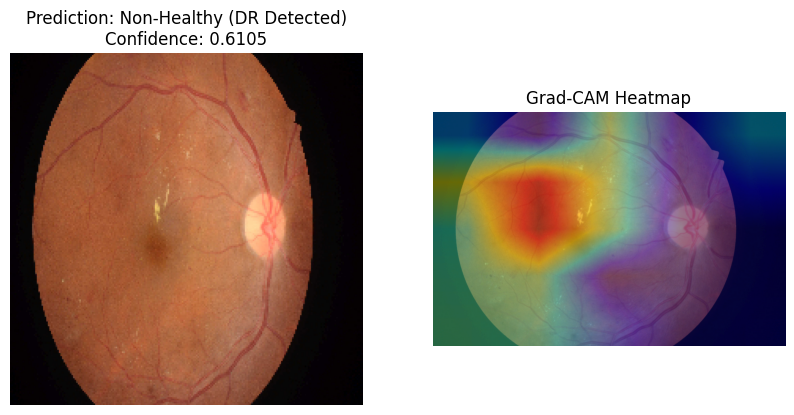

In [33]:
uploaded = files.upload()

image_name = list(uploaded.keys())[0]
print(f"Uploaded image: {image_name}")

model = load_model("/content/drive/MyDrive/dataset/best_model_balanced_inceptionv3.keras")

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    confidence = prediction[0][0]
    if confidence > 0.5:
        result = "Non-Healthy (DR Detected)"
    else:
        result = "Healthy (No DR)"
    return result, confidence, img_array

def grad_cam(img_array, model, last_conv_layer_name):

    grad_model = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap(img_path, heatmap):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return superimposed_img

result, confidence, img_array = predict_image(image_name)

img = image.load_img(image_name, target_size=(224, 224))
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {result}\nConfidence: {confidence:.4f}")

last_conv_layer_name = "mixed10"
heatmap = grad_cam(img_array, model, last_conv_layer_name)
superimposed_img = overlay_heatmap(image_name, heatmap)

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")
plt.axis('off')

plt.show()